In [1]:
'''
If you are running locally then 
1. reboot your local machine
2. create an environment called 'colab' using anaconda prompt
if you have a gpu
conda create -n colab python tensorflow-gpu 
if not 
conda create -n colab python tensorflow
3. to install jupyter notebook
conda install jupyter notebook
4. to go to the 'colab' environment
activate colab
5. change file path to locate this notebook and then type 'jupyter notebook'

If you use colab
1. save the data file in your google drive
2. goto colab and start running the code
'''

"\nIf you are running locally then \n1. reboot your local machine\n2. create an environment called 'colab' using anaconda prompt\nif you have a gpu\nconda create -n colab python tensorflow-gpu \nif not \nconda create -n colab python tensorflow\n3. to install jupyter notebook\nconda install jupyter notebook\n4. to go to the 'colab' environment\nactivate colab\n5. change file path to locate this notebook and then type 'jupyter notebook'\n\nIf you use colab\n1. save the data file in your google drive\n2. goto colab and start running the code\n"

In [2]:
#install prominent libraries with specific versions
#!pip install tensorflow==1.15.0
#!pip install keras==2.2.4-tf
#!pip install pandas==1.0.5
#!pip install sklearn==0.23.1
#!pip install matplotlib==3.2.2
#!pip install hyperas
#!pip install hyperopt

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import random
import pickle
import tensorflow as tf
#from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, CuDNNLSTM, CuDNNGRU, Input, Activation, Flatten, BatchNormalization, Reshape
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard, History, ReduceLROnPlateau
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras.models import Model, load_model, clone_model, save_model
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras import regularizers
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from matplotlib import style
from tensorflow.python.keras.optimizers import SGD, RMSprop, Adam, Adadelta
from tensorflow.python.keras.utils import np_utils
from sklearn.preprocessing import *
import datetime
from tqdm import tqdm
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from tensorflow.python.keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from tensorflow.python.keras.layers import Reshape, merge, Concatenate, Lambda, Average
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras.initializers import *
import hyperas
import hyperopt
from hyperas.distributions import choice, uniform
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe, rand
from sklearn.metrics import confusion_matrix, roc_auc_score
import itertools
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
import pandas_market_calendars as mcal 
import datetime 
from datetime import timedelta  
import yfinance as yf
import glob 

Using TensorFlow backend.


In [4]:
#Get library versions
print("tensorflow.__version__ = ", tf.__version__)
# print("keras.__version__ = ", keras.__version__)
import sklearn 
print("sklearn.__version__ = ", sklearn.__version__)
print("numpy.__version__ = ", np.__version__)
print("pandas.__version__ = ", pd.__version__)
import matplotlib
print("matplotlib.__version__ = ", matplotlib.__version__)
now = datetime.datetime.now()
today = now.strftime("%Y-%m-%d")
print ("Last run date : ", today)

tensorflow.__version__ =  1.15.0
sklearn.__version__ =  0.23.1
numpy.__version__ =  1.19.1
pandas.__version__ =  1.1.0
matplotlib.__version__ =  3.2.2
Last run date :  2021-05-01


In [5]:
'''
*****************************************************
please make sure the model_name is the same as the notebook
*****************************************************
'''
model_name = '6.1_Detailed_Multiple_Transformer_Multi_Day' # For hyperas, it is the notebook name (make sure the notebook resides in google drive if using colab)
max_evals = 20# number of hyperas evaluations for finding hyperparameters. More choices will require to higher evaluations
early_stopping_count= 200 # stop training run if there is no improvement in accuracy after the choosen epoch count
training_epochs=1000 # Note: hyperas epochs are different from training epochs
training_verbose = 2 #2choice 0, 1, 2 or False
checkpointer_verbose = 2 #2choice 0, 1, 2 or False
call_reduce_verbose = 1 #1choice 0, 1, 2 or False
training_starting_lr = 0.001


In [6]:
# change data parameters to improve accuracy
def data_params():
    """
    Function passes global data parameters to hyperas optim.minimize method.
    Please make ensure __pycache__ in your folder and and temp_model.py files are deleted 
    manually if you are making changes to these parameters
    """
    batch_size=128   # batch_size for training and evaluation
    time_steps = 42   # Number of time steps to create in the dataset
    rm_window =42    # Number of addtional rolling mean columns for choosen ticker price
    hyperas_epochs = 20  # number of epochs for each trails during hypears evaluation
    forecast_period = 7 # can be 1 to 7 in the 7day model
    '''
    ***********************************************************************************
    check to see if using 'RobustScaler','Normalizer', 'MinMaxScaler', 'MaxAbsScaler', 
    'PowerTransformer', 'QuantileTransformer' instead of 'StandardScaler' improves accuracy
    ***********************************************************************************
    '''
    x_scaler=StandardScaler() # change the method to improve accuracy
    
    return batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler

In [7]:
'''
***************************************************************************************************
Please choose 'True' or 'False' parameter for search, train and starting epoch one 
*****************************************************************************************************
'''

best_model_search = False # 'True' to search for best model, 'False' to use already saved existing best model
perform_training = True # 'True' to  train, 'False' to not to train after best_model search
starting_epoch_one = False # 'True' to train from scratch(epoch 1) , 'False' to load the last checkpoint weights of previous training run
evaluate_all_folds = True # evaluate the trained model for all the folds

In [8]:
def data_split():  
    kfold = False # 'True' to implement kfold, 'False' to use train_test_split
    train_size = 0.85  # use train_test_split between (0.7 to 0.9),make sure test is atleast of one batch_size
    shuffle = True # 'True' to shuffle
    split = 10 # number of splits in kfold
    fold_number = 8 # (the choosen fold_number of the split becomes test data, rest becomes train data)
    random_state= 54 # for random seed
    return kfold, train_size, shuffle, split, fold_number,random_state

In [9]:
if os.path.exists('best_model/'+model_name+'.h5'):
    print('Best model exists but you can still search for a better model')
    best_model_input_shape = load_model('best_model/'+model_name+'.h5').input_shape
        
else:
    print('Best model doesnt exist, changing best_model variable to True')
    best_model_search= True
    

if best_model_search and perform_training:
    print('you have choosen to search for best model and then train')
elif best_model_search and not perform_training:
    print('you have choosen to search for best model only')
elif not best_model_search and perform_training:
    print('you have choosen to train using already saved best model with 2 inputs')
    print('For training use best model first input size:', best_model_input_shape[0])
    print('For training use best model second input size:', best_model_input_shape[1])
elif not best_model_search and not perform_training:
     print('you have choosen to not to search or train. Therefore the model will not run')  

if os.path.exists('train_model/checkpoint/'+model_name+'_weights.h5'):
    print('check point exists with best weights')
    if os.path.exists('train_metrics/'+model_name+'.csv'):
        train_metrics = pd.read_csv('train_metrics/'+model_name+'.csv', index_col=0)
        print('\n','Results of last run checkpoint:')
        print(train_metrics.tail(1))       
else:
    print("check point doesn't exist, starting training from the epoch 1")
    starting_epoch_one = True 

Best model exists but you can still search for a better model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
you have choosen to train using already saved best model with 2 inputs
For training use best model first input size: (128, 42, 1202)
For training use best model second input size: (128, 42, 1202)
check point doesn't exist, starting training from the epoch 1


In [10]:
#random seed to generate reproduceable results
_, _, _, _, _, random_state = data_split()
from numpy.random import seed
seed(random_state)
try:
    tf.compat.v1.set_random_seed(random_state)
except:
    from tensorflow import set_random_seed
    set_random_seed(random_state)
random.seed(random_state)
os.environ['PYTHONHASHSEED']=str(1)
os.environ['TF_KERAS'] = '1'

In [11]:
# create these folders if they do not exist
def build_path(dirName):
    try:
        os.makedirs(dirName)    
        print("Directory " , dirName ,  " created ")
    except:
        print("Directory " , dirName ,  " already exists")  

In [12]:
# to check if GPU is getting used locally.....you need to see CPU as well as GPU in the output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 535139268315549257
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7125503181
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4666665866740295140
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [13]:
def feature_selection():
    
    '''
    Function reads the dataset and prepares inputs and labels
    '''
    ticker = '^GSPC'  # ticker to classify
    stocks = ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF-B', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CPRI', 'CPRT', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIA', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DLTR', 'DOV', 'DOW', 'DRE', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DX-Y.NYB', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FITB', 'FLIR', 'FLS', 'FLT', 'FMC', 'FOX', 'FOXA', 'FRC', 'FRT', 'FTI', 'FTNT', 'FTV', 'GD', 'GE', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GOOG', 'GPC', 'GPN', 'GPS', 'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HBI', 'HCA', 'HD', 'HES', 'HFC', 'HIG', 'HII', 'HLT', 'HOG', 'HOLX', 'HON', 'HP', 'HPE', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INFO', 'INTC', 'INTU', 'IP', 'IPG', 'IPGP', 'IQV', 'IR', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J', 'JBHT', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM', 'JWN', 'K', 'KEY', 'KEYS', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO', 'KR', 'KSS', 'KSU', 'L', 'LB', 'LDOS', 'LEG', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW', 'LRCX', 'LUV', 'LVS', 'LW', 'LYB', 'LYV', 'M', 'MA', 'MAA', 'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOS', 'MPC', 'MRK', 'MRO', 'MS', 'MSCI', 'MSFT', 'MSI', 'MTB', 'MTD', 'MU', 'MXIM', 'MYL', 'NBL', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NFLX', 'NI', 'NKE', 'NLOK', 'NLSN', 'NOC', 'NOV', 'NOW', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NVR', 'NWL', 'NWS', 'NWSA', 'O', 'ODFL', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OXY', 'PAYX', 'PBCT', 'PCAR', 'PEAK', 'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH', 'PHM', 'PKG', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL', 'PRGO', 'PRU', 'PSA', 'PSX', 'PVH', 'PWR', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'RE', 'REG', 'REGN', 'RF', 'RHI', 'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTN', 'SBAC', 'SBUX', 'SCHW', 'SEE', 'SHW', 'SIVB', 'SJM', 'SLB', 'SLG', 'SNA', 'SNPS', 'SO', 'SPG', 'SPGI', 'SPY', 'SRE', 'STE', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP', 'TDG', 'TEL', 'TFC', 'TFX', 'TGT', 'TIF', 'TJX', 'TMO', 'TMUS', 'TPR', 'TROW', 'TRV', 'TSCO', 'TSN', 'TTWO', 'TWTR', 'TXN', 'TXT', 'UA', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNM', 'UNP', 'UPS', 'URI', 'USB', 'UTX', 'V', 'VAR', 'VFC', 'VIAC', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VZ', 'WAB', 'WAT', 'WBA', 'WCG', 'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WLTW', 'WM', 'WMB', 'WMT', 'WRB', 'WRK', 'WU', 'WY', 'WYNN', 'XEC', 'XEL', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLNX', 'XLP', 'XLU', 'XLV', 'XLY', 'XOM', 'XRAY', 'XRT', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS', '^GSPC', '^IXIC', '^NDX', '^SOX', '^TNX', '^VIX', '^VVIX', '^VXN', '^VXO', '^VXV']
    short_interest = ['Trading Volume']
    nytimes = ['neg', 'neu', 'pos']
    economic = ['Dividend', 'Earnings', 'CPI', 'Long Interest Rate', 'Real Price', 'Real Dividend', 'Real Earnings', 'Cyclically Adjusted PE Ratio', 'ECRI USLEADING LEVEL', 'ECRI USLEADING GROWTH', 'ECRI USLAGGING LEVEL', 'ECRI USLAGGING GROWTH', 'ECRI_USCOIN LEVEL', 'ECRI_USCOIN GROWTH', 'University of Michigan Consumer Survey, Index of Consumer Sentiment', 'Bullish', 'Neutral', 'Bearish', 'Bullish 8-Week Mov Avg', 'Bull-Bear Spread', 'Bullish Average', 'Bullish Average + St. Dev', 'Bullish Average - St. Dev', 'Stock Market Confidence Indices - United States One Year Index Data - Individual', 'Stock Market Confidence Indices - United States One Year Index Data - Institutional', 'Stock Market Confidence Indices - United States Buy on Dips Confidence Index Data - Individual', 'Stock Market Confidence Indices - United States Buy on Dips Confidence Index Data - Institutional', 'Stock Market Confidence Indices - United States Crash Confidence Index Data - Individual', 'Stock Market Confidence Indices - United States Crash Confidence Index Data - Institutional', 'Stock Market Confidence Indices - United States Valuation Index Data - Individual', 'Stock Market Confidence Indices - United States Valuation Index Data - Institutional', 'Zillow Home Value Index (Metro): Zillow Rental Index - All Homes - United States', 'Zillow Home Value Index (Metro): Turnover - All Homes - United States', 'Zillow Home Value Index (Metro): Price To Rent Ratio - All Homes - United States', 'Zillow Home Value Index (Metro): Median Listing Price - All Homes - United States', 'Zillow Home Value Index (Metro):  Home Sold As Foreclosure - Ratio - All Homes - United States', 'Historical Housing Market Data - Real Home Price Index', 'Cost Index', 'U.S. Population (Millions)', 'Long Rate', 'Historical Housing Market Data - Nominal Home Price Index', 'Historical Housing Market Data - Consumer Price Index (Quarterly)', '30-Year Conventional Mortgage Rate', 'House Price Index - US National', '15-Year Fix Rate', '15-Year Fix Rate Fees & Points', '5-Year Adjustable Rate', '5-Year Adjustable Rate Fees & Points', '1-Year Adjustable Rate', '1-Year Adjustable Rate Fees & Points', '30-Year Fixed Rate Mortgage Average in the United States', 'Federal Funds Rate', '90 day T Bill Rate', 'One Year Maturity Treasury Yield', 'Ten Year Maturity Treasury Yield', 'Freddie Mac Commitment Fixed Rate Mortgages', 'Freddie Mac Commitment ARMs', 'Prime Rate', 'Total Housing Starts', 'Single Family Housing Starts', 'Multi-Family Housing Starts', 'New Single-Family Sales', 'Existing Single-Family Home Sales', '1-Year CD: National Rate of Banks', '5-Year CD: National Rate of Banks', 'Interest Checking Accounts: National Rate of Banks', 'Money Market Accounts: National Rate of Banks', '1-Month AA Financial Commercial Paper Rate', '3-Month AA Financial Commercial Paper Rate', '1-Month AA Nonfinancial Commercial Paper Rate', '3-Month AA Nonfinancial Commercial Paper Rate', 'Effective Federal Funds Rate', '10-Year Treasury Inflation-Indexed Security, Constant Maturity', '20-Year Treasury Inflation-Indexed Security, Constant Maturity', '30-Year Treasury Inflation-Indexed Security, Constant Maturity', '5-Year Treasury Inflation-Indexed Security, Constant Maturity', '7-Year Treasury Inflation-Indexed Security, Constant Maturity', '10-Year Treasury Constant Maturity Rate', '2-Year Treasury Constant Maturity Rate', '20-Year Treasury Constant Maturity Rate', '3-Year Treasury Constant Maturity Rate', '30-Year Treasury Constant Maturity Rate', '5-Year Treasury Constant Maturity Rate', '7-Year Treasury Constant Maturity Rate', 'Bank Prime Loan Rate', '1-Year Treasury Bill: Secondary Market Rate', '3-Month Treasury Bill: Secondary Market Rate', '4-Week Treasury Bill: Secondary Market Rate', '6-Month Treasury Bill: Secondary Market Rate', 'Overnight London Interbank Offered Rate (LIBOR), based on U.S. Dollar', 'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan', 'Commercial Bank Interest Rate on Credit Card Plans, All Accounts', 'RR3_TBILL_PGDP_2', 'RR3_TBILL_PGDP_3', 'RR3_TBILL_PGDP_4', 'RR3_TBILL_PGDP_5', 'RR2_TBILL_CCPI_2', 'RR2_TBILL_CCPI_3', 'RR2_TBILL_CCPI_4', 'RR2_TBILL_CCPI_5', 'Gross domestic product', 'Personal consumption expenditures', ':Goods', '::Durable goods', '::Nondurable goods', ':Services', 'Gross private domestic investment', 'Net exports of goods and services', 'Government consumption expenditures and gross investment', '::Gross domestic income (GDI)', '::Gross national product', '::Gross national income', '::Disposable personal income', 'Personal income', ':Compensation of employees', '::Wages and salaries', ':Population (midperiod; thousands)', '::Disposable personal income; current dollars', 'Services', ':Household consumption expenditures (for services)', '::Housing and utilities', '::Health care', '::Transportation services', '::Recreation services', '::Food services and accommodations', '::Financial services and insurance', '::Other services', 'Corporate profits with inventory valuation and capital consumption adjustments', 'Consumer Price Index - USA', 'United States Gross National Savings, % of GDP', 'United States GDP at Constant Prices, % change', 'Nominal Potential Gross Domestic Product', 'Industrial Production: Durable Goods: Other durable goods', 'FRED: Projection of General government net lending/borrowing for United States', 'FRED: Real Potential Gross Domestic Product', 'FRED: Real Gross Domestic Product', 'FRED: Gross Domestic Product', 'FRBP: GDPplus GDP Growth', 'Inflation YOY - USA', 'Consumer Price Index for All Urban Consumers: All Items', 'PRCCPI1', 'PRCCPI2', 'PRCCPI3', 'PRCCPI4', 'PRCCPI5', 'PRCCPI6', 'PRCCPI7', 'PRCCPI8', 'PRCCPI9', 'PRCCPI10', 'PRCCPI11', 'PRCCPI12', 'PRCCPI13', 'PRCCPI14', 'PRCCPI15', 'PRCCPI16', 'PRCCPI17', 'PRCCPI18', 'PRCCPI19', 'PRCCPI20', 'Mean CPI1', 'Mean CPI2', 'Mean CPI3', 'Mean CPI4', 'Mean CPI5', 'Mean CPI6', 'Mean CPIA', 'Mean CPIB', 'Mean CPIC', 'Median CPI1', 'Median CPI2', 'Median CPI3', 'Median CPI4', 'Median CPI5', 'Median CPI6', 'Median CPIA', 'Median CPIB', 'Median CPIC', 'CORECPI1', 'CORECPI2', 'CORECPI3', 'CORECPI4', 'CORECPI5', 'CORECPI6', 'CORECPIA', 'CORECPIB', 'CORECPIC', 'Median CORECPI1', 'Median CORECPI2', 'Median CORECPI3', 'Median CORECPI4', 'Median CORECPI5', 'Median CORECPI6', 'Median CORECPIA', 'Median CORECPIB', 'Median CORECPIC', 'Employment; Openings; All industries; Rate (Percent) - National', 'Employment; Gross Job Losses; All industries; Rate (Percent) - National', 'Employment - All employees, quarterly averages, seasonally adjusted, thousands; Total nonfarm industry', 'Employment - All employees, thousands; Total private industry', 'Employment - All employees, thousands; Total nonfarm industry', 'Hires for Total nonfarm in Total US Region', 'Layoffs and discharges for Total nonfarm in Total US Region', 'Total separations for Total nonfarm in Total US Region', 'Hires percent for Total private in Total US Region', 'Job openings for Total private in Total US Region', 'Job openings percent for Total private in Total US Region', 'Total separations for Total private in Total US Region', 'Hires for Construction in Total US Region', 'Total separations for Construction in Total US Region', 'Hires for Manufacturing in Total US Region', 'Hires for Government in Total US Region', 'Total separations for Government in Total US Region', 'US Forecast Unemployment Rate, % of Total Labor Force', 'ISM Manufacturing Employment Index', 'ISM Non-Manufacturing Employment Index', 'FRED Forecast Natural Rate of Unemployment (Short-Term)', 'FRED Forecast Natural Rate of Unemployment (Long-Term)', 'ADP_Total private', 'ADP_Goods producing', 'Service providing', 'ADP_Goods Producing Industries_1-19', 'ADP_Goods Producing Industries_20-49', 'ADP_Goods Producing Industries_1-49', 'ADP_Goods Producing Industries_50-499', 'ADP_Goods Producing Industries_500+', 'ADP_Goods Producing Industries_500-999', 'ADP_Goods Producing Industries_1,000+', 'ADP_Construction', 'ADP_Natural resources & mining', 'Manufacturing', 'ADP_Prof.l/business services', 'ADP_Professional services', 'ADP_Total Non-Farm Private_1-19', 'ADP_Total Non-Farm Private_20-49', 'ADP_Total Non-Farm Private_1-49', 'ADP_Total Non-Farm Private_50-499', 'ADP_Total Non-Farm Private_500+', 'ADP_Total Non-Farm Private_500-999', '1000+', 'ADP_Private Service_1-19', 'ADP_Private Service_20-49', 'ADP_Private Service_1-49', 'ADP_Private Service_50-499', 'ADP_Private Service_500+', 'ADP_Private Service_500-999', 'ADP_Private Service_1,000+', 'Hand to Mouth-Manufacturing Buying Policy: Capital Expenditures', 'Average Days-Manufacturing Buying Policy: Capital Expenditures', 'Hand to Mouth-Manufacturing Buying Policy: MRO Supplies', 'Average Days-Manufacturing Buying Policy: MRO Supplies', 'Manufacturing Backlog of Orders Index', "Manufacturing Customers' Inventories Index", 'Manufacturing Supplier Deliveries Index', 'Manufacturing New Export Orders Index', 'Manufacturing Imports Index', 'Manufacturing Inventories Index', 'Manufacturing New Orders Index', 'Manufacturing Prices Index', 'Manufacturing Production Index', 'Non-Manufacturing Backlog of Orders Index', 'Non-Manufacturing Business Activity Index', 'Non-Manufacturing Supplier Deliveries Index', 'Non-Manufacturing New Export Orders Index', 'Non-Manufacturing Imports Index', 'Non-Manufacturing Inventories Index', 'Non-Manufacturing Inventory Sentiment Index', 'Non-Manufacturing New Orders Index', 'NMI Non-Manufacturing Index', 'Non-Manufacturing Prices Index', 'Gold Prices (Daily) - Currency USD', 'Milk, Nonfat dry, Chicago', 'Crude Oil Futures, Continuous Contract #1 (CL1) (Front Month)', 'UK Natural Gas Futures, Continuous Contract', 'Natural Gas (Henry Hub) Physical Futures, Continuous Contract #1 (NG1) (Front Month)', 'STEO price forecast, Monthly', 'US All Grades Conventional Gas Price', 'Copper Prices', 'Aluminum Prices', 'Silver Price: London Fixing', 'Seasonal Factors for the Empire State Manufacturing Survey - Future General Business Conditions - Percent Reporting Increase', 'Empire State Manufacturing Index - Forecasted Inventories - Diffusion Index (Seasonally Adjusted)', 'Seasonal Factors for the Empire State Manufacturing Survey - Current New Orders - Percent Reporting Decrease', 'Seasonal Factors for the Empire State Manufacturing Survey - Current New Orders - Percent Reporting Increase', 'Empire State Manufacturing Index - Forecasted Shipments - Diffusion Index (Seasonally Adjusted)', 'Empire State Manufacturing Index - Forecasted Unfilled Orders - Diffusion Index (Seasonally Adjusted)', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future New Orders', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future Shipments', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future Unfilled Orders', 'Future New Orders;Percent Reporting Increases for FRB - Philadelphia District']
    pattern = ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'year_1971', 'year_1972', 'year_1973', 'year_1974', 'year_1975', 'year_1976', 'year_1977', 'year_1978', 'year_1979', 'year_1980', 'year_1981', 'year_1982', 'year_1983', 'year_1984', 'year_1985', 'year_1986', 'year_1987', 'year_1988', 'year_1989', 'year_1990', 'year_1991', 'year_1992', 'year_1993', 'year_1994', 'year_1995', 'year_1996', 'year_1997', 'year_1998', 'year_1999', 'year_2000', 'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'quarter_2', 'quarter_3', 'quarter_4', 'days_of_month_2', 'days_of_month_3', 'days_of_month_4', 'days_of_month_5', 'days_of_month_6', 'days_of_month_7', 'days_of_month_8', 'days_of_month_9', 'days_of_month_10', 'days_of_month_11', 'days_of_month_12', 'days_of_month_13', 'days_of_month_14', 'days_of_month_15', 'days_of_month_16', 'days_of_month_17', 'days_of_month_18', 'days_of_month_19', 'days_of_month_20', 'days_of_month_21', 'days_of_month_22', 'days_of_month_23', 'days_of_month_24', 'days_of_month_25', 'days_of_month_26', 'days_of_month_27', 'days_of_month_28', 'days_of_month_29', 'days_of_month_30', 'days_of_month_31', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'early_close']
    derivatives = ['CALLS', 'PUTS', 'TOTAL_PC', 'P/C Ratio']
    fama = ['ff_0.45', 'ff_-0.32', 'ff_-0.08', 'ff_0.009000000000000001', 'ff_-0.67', 'ff_0.0', 'ff_-0.32.1', 'ff_-0.01', 'ff_0.15', 'ff_0.012']
    correlations = ['corr^GSPC_A', 'corr^GSPC_AAL', 'corr^GSPC_AAP', 'corr^GSPC_AAPL', 'corr^GSPC_ABBV', 'corr^GSPC_ABC', 'corr^GSPC_ABMD', 'corr^GSPC_ABT', 'corr^GSPC_ACN', 'corr^GSPC_ADBE', 'corr^GSPC_ADI', 'corr^GSPC_ADM', 'corr^GSPC_ADP', 'corr^GSPC_ADS', 'corr^GSPC_ADSK', 'corr^GSPC_AEE', 'corr^GSPC_AEP', 'corr^GSPC_AES', 'corr^GSPC_AFL', 'corr^GSPC_AGN', 'corr^GSPC_AIG', 'corr^GSPC_AIV', 'corr^GSPC_AIZ', 'corr^GSPC_AJG', 'corr^GSPC_AKAM', 'corr^GSPC_ALB', 'corr^GSPC_ALGN', 'corr^GSPC_ALK', 'corr^GSPC_ALL', 'corr^GSPC_ALLE', 'corr^GSPC_ALXN', 'corr^GSPC_AMAT', 'corr^GSPC_AMCR', 'corr^GSPC_AMD', 'corr^GSPC_AME', 'corr^GSPC_AMG', 'corr^GSPC_AMGN', 'corr^GSPC_AMP', 'corr^GSPC_AMT', 'corr^GSPC_AMZN', 'corr^GSPC_ANET', 'corr^GSPC_ANSS', 'corr^GSPC_ANTM', 'corr^GSPC_AON', 'corr^GSPC_AOS', 'corr^GSPC_APA', 'corr^GSPC_APD', 'corr^GSPC_APH', 'corr^GSPC_APTV', 'corr^GSPC_ARE', 'corr^GSPC_ARNC', 'corr^GSPC_ATO', 'corr^GSPC_ATVI', 'corr^GSPC_AVB', 'corr^GSPC_AVGO', 'corr^GSPC_AVY', 'corr^GSPC_AWK', 'corr^GSPC_AXP', 'corr^GSPC_AZO', 'corr^GSPC_BA', 'corr^GSPC_BAC', 'corr^GSPC_BAX', 'corr^GSPC_BBY', 'corr^GSPC_BDX', 'corr^GSPC_BEN', 'corr^GSPC_BF-B', 'corr^GSPC_BIIB', 'corr^GSPC_BK', 'corr^GSPC_BKNG', 'corr^GSPC_BKR', 'corr^GSPC_BLK', 'corr^GSPC_BLL', 'corr^GSPC_BMY', 'corr^GSPC_BR', 'corr^GSPC_BRK-B', 'corr^GSPC_BSX', 'corr^GSPC_BWA', 'corr^GSPC_BXP', 'corr^GSPC_C', 'corr^GSPC_CAG', 'corr^GSPC_CAH', 'corr^GSPC_CAT', 'corr^GSPC_CB', 'corr^GSPC_CBOE', 'corr^GSPC_CBRE', 'corr^GSPC_CCI', 'corr^GSPC_CCL', 'corr^GSPC_CDNS', 'corr^GSPC_CDW', 'corr^GSPC_CE', 'corr^GSPC_CERN', 'corr^GSPC_CF', 'corr^GSPC_CFG', 'corr^GSPC_CHD', 'corr^GSPC_CHRW', 'corr^GSPC_CHTR', 'corr^GSPC_CI', 'corr^GSPC_CINF', 'corr^GSPC_CL', 'corr^GSPC_CLX', 'corr^GSPC_CMA', 'corr^GSPC_CMCSA', 'corr^GSPC_CME', 'corr^GSPC_CMG', 'corr^GSPC_CMI', 'corr^GSPC_CMS', 'corr^GSPC_CNC', 'corr^GSPC_CNP', 'corr^GSPC_COF', 'corr^GSPC_COG', 'corr^GSPC_COO', 'corr^GSPC_COP', 'corr^GSPC_COST', 'corr^GSPC_COTY', 'corr^GSPC_CPB', 'corr^GSPC_CPRI', 'corr^GSPC_CPRT', 'corr^GSPC_CRM', 'corr^GSPC_CSCO', 'corr^GSPC_CSX', 'corr^GSPC_CTAS', 'corr^GSPC_CTL', 'corr^GSPC_CTSH', 'corr^GSPC_CTVA', 'corr^GSPC_CTXS', 'corr^GSPC_CVS', 'corr^GSPC_CVX', 'corr^GSPC_CXO', 'corr^GSPC_D', 'corr^GSPC_DAL', 'corr^GSPC_DD', 'corr^GSPC_DE', 'corr^GSPC_DFS', 'corr^GSPC_DG', 'corr^GSPC_DGX', 'corr^GSPC_DHI', 'corr^GSPC_DHR', 'corr^GSPC_DIA', 'corr^GSPC_DIS', 'corr^GSPC_DISCA', 'corr^GSPC_DISCK', 'corr^GSPC_DISH', 'corr^GSPC_DLR', 'corr^GSPC_DLTR', 'corr^GSPC_DOV', 'corr^GSPC_DOW', 'corr^GSPC_DRE', 'corr^GSPC_DRI', 'corr^GSPC_DTE', 'corr^GSPC_DUK', 'corr^GSPC_DVA', 'corr^GSPC_DVN', 'corr^GSPC_DX-Y.NYB', 'corr^GSPC_DXC', 'corr^GSPC_EA', 'corr^GSPC_EBAY', 'corr^GSPC_ECL', 'corr^GSPC_ED', 'corr^GSPC_EFX', 'corr^GSPC_EIX', 'corr^GSPC_EL', 'corr^GSPC_EMN', 'corr^GSPC_EMR', 'corr^GSPC_EOG', 'corr^GSPC_EQIX', 'corr^GSPC_EQR', 'corr^GSPC_ES', 'corr^GSPC_ESS', 'corr^GSPC_ETFC', 'corr^GSPC_ETN', 'corr^GSPC_ETR', 'corr^GSPC_EVRG', 'corr^GSPC_EW', 'corr^GSPC_EXC', 'corr^GSPC_EXPD', 'corr^GSPC_EXPE', 'corr^GSPC_EXR', 'corr^GSPC_F', 'corr^GSPC_FANG', 'corr^GSPC_FAST', 'corr^GSPC_FB', 'corr^GSPC_FBHS', 'corr^GSPC_FCX', 'corr^GSPC_FDX', 'corr^GSPC_FE', 'corr^GSPC_FFIV', 'corr^GSPC_FIS', 'corr^GSPC_FISV', 'corr^GSPC_FITB', 'corr^GSPC_FLIR', 'corr^GSPC_FLS', 'corr^GSPC_FLT', 'corr^GSPC_FMC', 'corr^GSPC_FOX', 'corr^GSPC_FOXA', 'corr^GSPC_FRC', 'corr^GSPC_FRT', 'corr^GSPC_FTI', 'corr^GSPC_FTNT', 'corr^GSPC_FTV', 'corr^GSPC_GD', 'corr^GSPC_GE', 'corr^GSPC_GILD', 'corr^GSPC_GIS', 'corr^GSPC_GL', 'corr^GSPC_GLW', 'corr^GSPC_GM', 'corr^GSPC_GOOG', 'corr^GSPC_GPC', 'corr^GSPC_GPN', 'corr^GSPC_GPS', 'corr^GSPC_GRMN', 'corr^GSPC_GS', 'corr^GSPC_GWW', 'corr^GSPC_HAL', 'corr^GSPC_HAS', 'corr^GSPC_HBAN', 'corr^GSPC_HBI', 'corr^GSPC_HCA', 'corr^GSPC_HD', 'corr^GSPC_HES', 'corr^GSPC_HFC', 'corr^GSPC_HIG', 'corr^GSPC_HII', 'corr^GSPC_HLT', 'corr^GSPC_HOG', 'corr^GSPC_HOLX', 'corr^GSPC_HON', 'corr^GSPC_HP', 'corr^GSPC_HPE', 'corr^GSPC_HPQ', 'corr^GSPC_HRB', 'corr^GSPC_HRL', 'corr^GSPC_HSIC', 'corr^GSPC_HST', 'corr^GSPC_HSY', 'corr^GSPC_HUM', 'corr^GSPC_IBM', 'corr^GSPC_ICE', 'corr^GSPC_IDXX', 'corr^GSPC_IEX', 'corr^GSPC_IFF', 'corr^GSPC_ILMN', 'corr^GSPC_INCY', 'corr^GSPC_INFO', 'corr^GSPC_INTC', 'corr^GSPC_INTU', 'corr^GSPC_IP', 'corr^GSPC_IPG', 'corr^GSPC_IPGP', 'corr^GSPC_IQV', 'corr^GSPC_IR', 'corr^GSPC_IRM', 'corr^GSPC_ISRG', 'corr^GSPC_IT', 'corr^GSPC_ITW', 'corr^GSPC_IVZ', 'corr^GSPC_JBHT', 'corr^GSPC_JCI', 'corr^GSPC_JEC', 'corr^GSPC_JKHY', 'corr^GSPC_JNJ', 'corr^GSPC_JNPR', 'corr^GSPC_JPM', 'corr^GSPC_JWN', 'corr^GSPC_K', 'corr^GSPC_KEY', 'corr^GSPC_KEYS', 'corr^GSPC_KHC', 'corr^GSPC_KIM', 'corr^GSPC_KLAC', 'corr^GSPC_KMB', 'corr^GSPC_KMI', 'corr^GSPC_KMX', 'corr^GSPC_KO', 'corr^GSPC_KR', 'corr^GSPC_KSS', 'corr^GSPC_KSU', 'corr^GSPC_L', 'corr^GSPC_LB', 'corr^GSPC_LDOS', 'corr^GSPC_LEG', 'corr^GSPC_LEN', 'corr^GSPC_LH', 'corr^GSPC_LHX', 'corr^GSPC_LIN', 'corr^GSPC_LKQ', 'corr^GSPC_LLY', 'corr^GSPC_LMT', 'corr^GSPC_LNC', 'corr^GSPC_LNT', 'corr^GSPC_LOW', 'corr^GSPC_LRCX', 'corr^GSPC_LUV', 'corr^GSPC_LVS', 'corr^GSPC_LW', 'corr^GSPC_LYB', 'corr^GSPC_M', 'corr^GSPC_MA', 'corr^GSPC_MAA', 'corr^GSPC_MAC', 'corr^GSPC_MAR', 'corr^GSPC_MAS', 'corr^GSPC_MCD', 'corr^GSPC_MCHP', 'corr^GSPC_MCK', 'corr^GSPC_MCO', 'corr^GSPC_MDLZ', 'corr^GSPC_MDT', 'corr^GSPC_MET', 'corr^GSPC_MGM', 'corr^GSPC_MHK', 'corr^GSPC_MKC', 'corr^GSPC_MKTX', 'corr^GSPC_MLM', 'corr^GSPC_MMC', 'corr^GSPC_MMM', 'corr^GSPC_MNST', 'corr^GSPC_MO', 'corr^GSPC_MOS', 'corr^GSPC_MPC', 'corr^GSPC_MRK', 'corr^GSPC_MRO', 'corr^GSPC_MS', 'corr^GSPC_MSCI', 'corr^GSPC_MSFT', 'corr^GSPC_MSI', 'corr^GSPC_MTB', 'corr^GSPC_MTD', 'corr^GSPC_MU', 'corr^GSPC_MXIM', 'corr^GSPC_MYL', 'corr^GSPC_NBL', 'corr^GSPC_NCLH', 'corr^GSPC_NDAQ', 'corr^GSPC_NEE', 'corr^GSPC_NEM', 'corr^GSPC_NFLX', 'corr^GSPC_NI', 'corr^GSPC_NKE', 'corr^GSPC_NLOK', 'corr^GSPC_NLSN', 'corr^GSPC_NOC', 'corr^GSPC_NOV', 'corr^GSPC_NOW', 'corr^GSPC_NRG', 'corr^GSPC_NSC', 'corr^GSPC_NTAP', 'corr^GSPC_NTRS', 'corr^GSPC_NUE', 'corr^GSPC_NVDA', 'corr^GSPC_NVR', 'corr^GSPC_NWL', 'corr^GSPC_NWS', 'corr^GSPC_NWSA', 'corr^GSPC_O', 'corr^GSPC_ODFL', 'corr^GSPC_OKE', 'corr^GSPC_OMC', 'corr^GSPC_ORCL', 'corr^GSPC_ORLY', 'corr^GSPC_OXY', 'corr^GSPC_PAYX', 'corr^GSPC_PBCT', 'corr^GSPC_PCAR', 'corr^GSPC_PEAK', 'corr^GSPC_PEG', 'corr^GSPC_PEP', 'corr^GSPC_PFE', 'corr^GSPC_PFG', 'corr^GSPC_PG', 'corr^GSPC_PGR', 'corr^GSPC_PH', 'corr^GSPC_PHM', 'corr^GSPC_PKG', 'corr^GSPC_PKI', 'corr^GSPC_PLD', 'corr^GSPC_PM', 'corr^GSPC_PNC', 'corr^GSPC_PNR', 'corr^GSPC_PNW', 'corr^GSPC_PPG', 'corr^GSPC_PPL', 'corr^GSPC_PRGO', 'corr^GSPC_PRU', 'corr^GSPC_PSA', 'corr^GSPC_PSX', 'corr^GSPC_PVH', 'corr^GSPC_PWR', 'corr^GSPC_PXD', 'corr^GSPC_PYPL', 'corr^GSPC_QCOM', 'corr^GSPC_QRVO', 'corr^GSPC_RCL', 'corr^GSPC_RE', 'corr^GSPC_REG', 'corr^GSPC_REGN', 'corr^GSPC_RF', 'corr^GSPC_RHI', 'corr^GSPC_RJF', 'corr^GSPC_RL', 'corr^GSPC_RMD', 'corr^GSPC_ROK', 'corr^GSPC_ROL', 'corr^GSPC_ROP', 'corr^GSPC_ROST', 'corr^GSPC_RSG', 'corr^GSPC_RTN', 'corr^GSPC_SBAC', 'corr^GSPC_SBUX', 'corr^GSPC_SCHW', 'corr^GSPC_SEE', 'corr^GSPC_SHW', 'corr^GSPC_SIVB', 'corr^GSPC_SJM', 'corr^GSPC_SLB', 'corr^GSPC_SLG', 'corr^GSPC_SNA', 'corr^GSPC_SNPS', 'corr^GSPC_SO', 'corr^GSPC_SPG', 'corr^GSPC_SPGI', 'corr^GSPC_SPY', 'corr^GSPC_SRE', 'corr^GSPC_STT', 'corr^GSPC_STX', 'corr^GSPC_STZ', 'corr^GSPC_SWK', 'corr^GSPC_SWKS', 'corr^GSPC_SYF', 'corr^GSPC_SYK', 'corr^GSPC_SYY', 'corr^GSPC_T', 'corr^GSPC_TAP', 'corr^GSPC_TDG', 'corr^GSPC_TEL', 'corr^GSPC_TFC', 'corr^GSPC_TFX', 'corr^GSPC_TGT', 'corr^GSPC_TIF', 'corr^GSPC_TJX', 'corr^GSPC_TMO', 'corr^GSPC_TMUS', 'corr^GSPC_TPR', 'corr^GSPC_TRIP', 'corr^GSPC_TROW', 'corr^GSPC_TRV', 'corr^GSPC_TSCO', 'corr^GSPC_TSN', 'corr^GSPC_TTWO', 'corr^GSPC_TWTR', 'corr^GSPC_TXN', 'corr^GSPC_TXT', 'corr^GSPC_UA', 'corr^GSPC_UAA', 'corr^GSPC_UAL', 'corr^GSPC_UDR', 'corr^GSPC_UHS', 'corr^GSPC_ULTA', 'corr^GSPC_UNH', 'corr^GSPC_UNM', 'corr^GSPC_UNP', 'corr^GSPC_UPS', 'corr^GSPC_URI', 'corr^GSPC_USB', 'corr^GSPC_UTX', 'corr^GSPC_V', 'corr^GSPC_VAR', 'corr^GSPC_VFC', 'corr^GSPC_VIAC', 'corr^GSPC_VLO', 'corr^GSPC_VMC', 'corr^GSPC_VNO', 'corr^GSPC_VRSK', 'corr^GSPC_VRSN', 'corr^GSPC_VRTX', 'corr^GSPC_VTR', 'corr^GSPC_VZ', 'corr^GSPC_WAB', 'corr^GSPC_WAT', 'corr^GSPC_WBA', 'corr^GSPC_WCG', 'corr^GSPC_WDC', 'corr^GSPC_WEC', 'corr^GSPC_WELL', 'corr^GSPC_WFC', 'corr^GSPC_WHR', 'corr^GSPC_WLTW', 'corr^GSPC_WM', 'corr^GSPC_WMB', 'corr^GSPC_WMT', 'corr^GSPC_WRB', 'corr^GSPC_WRK', 'corr^GSPC_WU', 'corr^GSPC_WY', 'corr^GSPC_WYNN', 'corr^GSPC_XEC', 'corr^GSPC_XEL', 'corr^GSPC_XLB', 'corr^GSPC_XLE', 'corr^GSPC_XLF', 'corr^GSPC_XLI', 'corr^GSPC_XLK', 'corr^GSPC_XLNX', 'corr^GSPC_XLP', 'corr^GSPC_XLU', 'corr^GSPC_XLV', 'corr^GSPC_XLY', 'corr^GSPC_XOM', 'corr^GSPC_XRAY', 'corr^GSPC_XRT', 'corr^GSPC_XRX', 'corr^GSPC_XYL', 'corr^GSPC_YUM', 'corr^GSPC_ZBH', 'corr^GSPC_ZION', 'corr^GSPC_ZTS', 'corr^GSPC_^IXIC', 'corr^GSPC_^NDX', 'corr^GSPC_^SOX', 'corr^GSPC_^TNX', 'corr^GSPC_^VIX', 'corr^GSPC_^VVIX', 'corr^GSPC_^VXN', 'corr^GSPC_^VXO', 'corr^GSPC_^VXV']
    technicals = ['50Minus200_dayMA', '15_dayMA', 'Bol_upper_band', 'Bol_lower_band', 'percent_b', 'Advance_Decline_ratio', '1AD', '2ADD', '3ADOSC', '4ADX', '5ADXR', '6APO', '7AROON DOWN', '7AROON UP', '8AROONOSC', '9ASIN_ADJCLOSE', '10ASIN_HIGH', '11ASIN_LOW', '12ATR', '13AVGPRICE', '14UPPER BAND', '14MIDDLE BAND', '14LOWER BAND', '15rm_return', '15upperband_return', '15lowerband_return', '16BETA', '17BETAMARKET', '18BOP', '19CCI', '20CDL2CROWS', '21CDL3BLACKCROWS', '22CDL3INSIDE', '23CDL3LINESTRIKE', '24CDL3OUTSIDE', '25CDL3STARSINSOUTH', '26CDL3WHITESOLDIERS', '27CDLABANDONEDBABY', '28CDLADVANCEBLOCK', '29CDLBELTHOLD', '30CDLBREAKAWAY0', '31CDLCLOSINGMARUBOZU', '32CDLCONCEALBABYSWALL', '33CDLCOUNTERATTACK', '34CDLDARKCLOUDCOVER', '35CDLDOJI', '36CDLDOJISTAR', '37CDLDRAGONFLYDOJI', '38CDLENGULFING', '39CDLEVENINGDOJISTAR', '40CDLEVENINGSTAR', '41CDLGAPSIDESIDEWHITE', '42CDLGRAVESTONEDOJI', '43CDLHAMMER', '44CDLHANGINGMAN', '45CDLHARAMI', '46CDLHARAMICROSS', '47CDLHIGHWAVE', '48CDLHIKKAKE', '49CDLHIKKAKEMOD', '50CDLHOMINGPIGEON', '51CDLIDENTICAL3CROWS0', '52CDLINNECK', '53CDLINVERTEDHAMMER', '54CDLKICKING', '55CDLKICKINGBYLENGTH', '56CDLLADDERBOTTOM', '57CDLLONGLEGGEDDOJI', '58CDLLONGLINE', '59CDLMARUBOZU', '60CDLMATCHINGLOW', '61CDLMATHOLD', '62CDLMORNINGDOJISTAR', '63CDLMORNINGSTAR', '64CDLONNECK', '65CDLPIERCING', '66CDLRICKSHAWMAN', '67CDLRISEFALL3METHODS', '68CDLSEPARATINGLINES', '69CDLSHOOTINGSTAR', '70CDLSHORTLINE', '71CDLSPINNINGTOP', '72CDLSTALLEDPATTERN', '73CDLSTICKSANDWICH', '74CDLTAKURI', '75CDLTASUKIGAP', '76CDLTHRUSTING', '77CDLTRISTAR', '78CDLUNIQUE3RIVER', '79CDLUPSIDEGAP2CROWS', '80CDLXSIDEGAP3METHODS', '81CMO', '82CORREL', '83CORRELMARKET', '84COSH_ADJCLOSE', '85COSH_HIGH', '86COSH_LOW', '87COS_ADJCLOSE', '88COS_HIGH', '89COS_LOW', '90DEMA', '91DIV', '92DX', '93EMA', '94daily_returns', '94excess_returns', '95EXP', '96HIGHLOW', '97HT_DCPERIOD', '98HT_DCPHASE', '99INPHASE', '99QUADRATURE', '100SINE', '100LEADSINE', '101HT_TRENDLINE', '102HT_TRENDMODE', '103KAMA', '104LINEARREG_AD', '105LINEARREG_ADJCLOSE', '106LINEARREG_ADOSC', '107LINEARREG_ADX', '108LINEARREG_ADXR', '109LINEARREG_ANGLE_AD', '110LINEARREG_ANGLE_ADJCLOSE', '111LINEARREG_ANGLE_ADOSC', '112LINEARREG_ANGLE_ADX', '113LINEARREG_ANGLE_ADXR', '114LINEARREG_ANGLE_APO', '115LINEARREG_ANGLE_AROONOSC', '116LINEARREG_ANGLE_AROON_DOWN', '117LINEARREG_ANGLE_AROON_UP', '118LINEARREG_ANGLE_ATR', '119LINEARREG_ANGLE_BOP', '120LINEARREG_ANGLE_CCI', '121LINEARREG_ANGLE_CMO', '122LINEARREG_ANGLE_DEMA', '123LINEARREG_ANGLE_DX', '124LINEARREG_ANGLE_FAMA', '125LINEARREG_ANGLE_FASTD', '126LINEARREG_ANGLE_FASTDR', '127LINEARREG_ANGLE_FASTK', '128LINEARREG_ANGLE_FASTKR', '129LINEARREG_ANGLE_HIGH', '130LINEARREG_ANGLE_HT_DCPERIOD', '131LINEARREG_ANGLE_HT_DCPHASE', '132LINEARREG_ANGLE_HT_TRENDLINE', '133LINEARREG_ANGLE_INPHASE', '134LINEARREG_ANGLE_KAMA', '135LINEARREG_ANGLE_LEADSINE', '136LINEARREG_ANGLE_LOW', '137LINEARREG_ANGLE_LOWER_BAND', '138LINEARREG_ANGLE_MAMA', '139LINEARREG_ANGLE_MFI', '140LINEARREG_ANGLE_MIDDLE_BAND', '141LINEARREG_ANGLE_MINUS_DI', '142LINEARREG_ANGLE_MINUS_DM', '143LINEARREG_ANGLE_MOM', '144LINEARREG_ANGLE_NATR', '145LINEARREG_ANGLE_OBV', '146LINEARREG_ANGLE_PLUS_DI', '147LINEARREG_ANGLE_PLUS_DM', '148LINEARREG_ANGLE_PPO', '149LINEARREG_ANGLE_QUADRATURE', '150LINEARREG_ANGLE_ROC', '151LINEARREG_ANGLE_ROCP', '152LINEARREG_ANGLE_ROCR', '153LINEARREG_ANGLE_ROCR100', '154LINEARREG_ANGLE_RSI', '155LINEARREG_ANGLE_SAR', '156LINEARREG_ANGLE_SAREXT', '157LINEARREG_ANGLE_SINE', '158LINEARREG_ANGLE_SLOWD', '159LINEARREG_ANGLE_SLOWK', '160LINEARREG_ANGLE_T3', '161LINEARREG_ANGLE_TEMA', '162LINEARREG_ANGLE_TRANGE', '163LINEARREG_ANGLE_TRIMA', '164LINEARREG_ANGLE_TRIX', '165LINEARREG_ANGLE_ULTOSC', '166LINEARREG_ANGLE_UPPER_BAND', '167LINEARREG_ANGLE_WILLR', '168LINEARREG_ANGLE_WMA', '169LINEARREG_APO', '170LINEARREG_AROONOSC', '171LINEARREG_AROON_DOWN', '172LINEARREG_AROON_UP', '173LINEARREG_ATR', '174LINEARREG_BOP', '175LINEARREG_CCI', '176LINEARREG_CMO', '177LINEARREG_DEMA', '178LINEARREG_DX', '179LINEARREG_FAMA', '180LINEARREG_FASTD', '181LINEARREG_FASTDR', '182LINEARREG_FASTK', '183LINEARREG_FASTKR', '184LINEARREG_HIGH', '185LINEARREG_HT_DCPERIOD', '186LINEARREG_HT_DCPHASE', '187LINEARREG_HT_TRENDLINE', '188LINEARREG_INPHASE', '189LINEARREG_INTERCEPT_AD', '190LINEARREG_INTERCEPT_ADJCLOSE', '191LINEARREG_INTERCEPT_ADOSC', '192LINEARREG_INTERCEPT_ADX', '193LINEARREG_INTERCEPT_ADXR', '194LINEARREG_INTERCEPT_APO', '195LINEARREG_INTERCEPT_AROONOSC', '196LINEARREG_INTERCEPT_AROON_DOWN', '197LINEARREG_INTERCEPT_AROON_UP', '198LINEARREG_INTERCEPT_ATR', '199LINEARREG_INTERCEPT_BOP', '200LINEARREG_INTERCEPT_CCI', '201LINEARREG_INTERCEPT_CMO', '202LINEARREG_INTERCEPT_DEMA', '203LINEARREG_INTERCEPT_DX', '204LINEARREG_INTERCEPT_FAMA', '205LINEARREG_INTERCEPT_FASTD', '206LINEARREG_INTERCEPT_FASTDR', '207LINEARREG_INTERCEPT_FASTK', '208LINEARREG_INTERCEPT_FASTKR', '209LINEARREG_INTERCEPT_HIGH', '210LINEARREG_INTERCEPT_HT_DCPERIOD', '211LINEARREG_INTERCEPT_HT_DCPHASE', '212LINEARREG_INTERCEPT_HT_TRENDLINE', '213LINEARREG_INTERCEPT_INPHASE', '214LINEARREG_INTERCEPT_KAMA', '215LINEARREG_INTERCEPT_LEADSINE', '216LINEARREG_INTERCEPT_LOW', '217LINEARREG_INTERCEPT_LOWER_BAND', '218LINEARREG_INTERCEPT_MAMA', '219LINEARREG_INTERCEPT_MFI', '220LINEARREG_INTERCEPT_MIDDLE_BAND', '221LINEARREG_INTERCEPT_MINUS_DI', '222LINEARREG_INTERCEPT_MINUS_DM', '223LINEARREG_INTERCEPT_MOM', '224LINEARREG_INTERCEPT_NATR', '225LINEARREG_INTERCEPT_OBV', '226LINEARREG_INTERCEPT_PLUS_DI', '227LINEARREG_INTERCEPT_PLUS_DM', '228LINEARREG_INTERCEPT_PPO', '229LINEARREG_INTERCEPT_QUADRATURE', '230LINEARREG_INTERCEPT_ROC', '231LINEARREG_INTERCEPT_ROCP', '232LINEARREG_INTERCEPT_ROCR', '233LINEARREG_INTERCEPT_ROCR100', '234LINEARREG_INTERCEPT_RSI', '235LINEARREG_INTERCEPT_SAR', '236LINEARREG_INTERCEPT_SAREXT', '237LINEARREG_INTERCEPT_SINE', '238LINEARREG_INTERCEPT_SLOWD', '239LINEARREG_INTERCEPT_SLOWK', '240LINEARREG_INTERCEPT_T3', '241LINEARREG_INTERCEPT_TEMA', '242LINEARREG_INTERCEPT_TRANGE', '243LINEARREG_INTERCEPT_TRIMA', '244LINEARREG_INTERCEPT_TRIX', '245LINEARREG_INTERCEPT_ULTOSC', '246LINEARREG_INTERCEPT_UPPER_BAND', '247LINEARREG_INTERCEPT_WILLR', '248LINEARREG_INTERCEPT_WMA', '249LINEARREG_KAMA', '250LINEARREG_LEADSINE', '251LINEARREG_LOW', '252LINEARREG_LOWER_BAND', '253LINEARREG_MAMA', '254LINEARREG_MFI', '255LINEARREG_MIDDLE_BAND', '256LINEARREG_MINUS_DI', '257LINEARREG_MINUS_DM', '258LINEARREG_MOM', '259LINEARREG_NATR', '260LINEARREG_OBV', '261LINEARREG_PLUS_DI', '262LINEARREG_PLUS_DM', '263LINEARREG_PPO', '264LINEARREG_QUADRATURE', '265LINEARREG_ROC', '266LINEARREG_ROCP', '267LINEARREG_ROCR', '268LINEARREG_ROCR100', '269LINEARREG_RSI', '270LINEARREG_SAR', '271LINEARREG_SAREXT', '272LINEARREG_SINE', '273LINEARREG_SLOPE_AD', '274LINEARREG_SLOPE_ADJCLOSE', '275LINEARREG_SLOPE_ADOSC', '276LINEARREG_SLOPE_ADX', '277LINEARREG_SLOPE_ADXR', '278LINEARREG_SLOPE_APO', '279LINEARREG_SLOPE_AROONOSC', '280LINEARREG_SLOPE_AROON_DOWN', '281LINEARREG_SLOPE_AROON_UP', '282LINEARREG_SLOPE_ATR', '283LINEARREG_SLOPE_BOP', '284LINEARREG_SLOPE_CCI', '285LINEARREG_SLOPE_CMO', '286LINEARREG_SLOPE_DEMA', '287LINEARREG_SLOPE_DX', '288LINEARREG_SLOPE_FAMA', '289LINEARREG_SLOPE_FASTD', '290LINEARREG_SLOPE_FASTDR', '291LINEARREG_SLOPE_FASTK', '292LINEARREG_SLOPE_FASTKR', '293LINEARREG_SLOPE_HIGH', '294LINEARREG_SLOPE_HT_DCPERIOD', '295LINEARREG_SLOPE_HT_DCPHASE', '296LINEARREG_SLOPE_HT_TRENDLINE', '297LINEARREG_SLOPE_INPHASE', '298LINEARREG_SLOPE_KAMA', '299LINEARREG_SLOPE_LEADSINE', '300LINEARREG_SLOPE_LOW', '301LINEARREG_SLOPE_LOWER_BAND', '302LINEARREG_SLOPE_MAMA', '303LINEARREG_SLOPE_MFI', '304LINEARREG_SLOPE_MIDDLE_BAND', '305LINEARREG_SLOPE_MINUS_DI', '306LINEARREG_SLOPE_MINUS_DM', '307LINEARREG_SLOPE_MOM', '308LINEARREG_SLOPE_NATR', '309LINEARREG_SLOPE_OBV', '310LINEARREG_SLOPE_PLUS_DI', '311LINEARREG_SLOPE_PLUS_DM', '312LINEARREG_SLOPE_PPO', '313LINEARREG_SLOPE_QUADRATURE', '314LINEARREG_SLOPE_ROC', '315LINEARREG_SLOPE_ROCP', '316LINEARREG_SLOPE_ROCR', '317LINEARREG_SLOPE_ROCR100', '318LINEARREG_SLOPE_RSI', '319LINEARREG_SLOPE_SAR', '320LINEARREG_SLOPE_SAREXT', '321LINEARREG_SLOPE_SINE', '322LINEARREG_SLOPE_SLOWD', '323LINEARREG_SLOPE_SLOWK', '324LINEARREG_SLOPE_T3', '325LINEARREG_SLOPE_TEMA', '326LINEARREG_SLOPE_TRANGE', '327LINEARREG_SLOPE_TRIMA', '328LINEARREG_SLOPE_TRIX', '329LINEARREG_SLOPE_ULTOSC', '330LINEARREG_SLOPE_UPPER_BAND', '331LINEARREG_SLOPE_WILLR', '332LINEARREG_SLOPE_WMA', '333LINEARREG_SLOWD', '334LINEARREG_SLOWK', '335LINEARREG_T3', '336LINEARREG_TEMA', '337LINEARREG_TRANGE', '338LINEARREG_TRIMA', '339LINEARREG_TRIX', '340LINEARREG_ULTOSC', '341LINEARREG_UPPER_BAND', '342LINEARREG_WILLR', '343LINEARREG_WMA', '344LN_ADJCLOSE', '345LN_HIGH', '346LN_LOW', '347LOG10_ADJCLOSE', '348LOG10_HIGH', '349LOG10_LOW', '350MACD', '350MACD SIGNAL', '350MACD HIST', '351MACD', '351MACD SIGNAL', '351MACD HIST', '352MACD', '352MACD SIGNAL', '352MACD HIST', '353MAMA', '353FAMA', '354MEDPRICE', '355MFI', '356MIDPOINT', '357MIDPRICE', '358MIN', '358MAX', '359MINIDX', '359MAXIDX', '360MINUS_DI', '361MINUS_DM', '362MOM', '363MULT', '364NATR', '365OBV', '366PLUS_DI', '367PLUS_DM', '368PPO', '369^GSPC_rm_2', '369^GSPC_rm_3', '369^GSPC_rm_4', '369^GSPC_rm_5', '369^GSPC_rm_6', '369^GSPC_rm_7', '369^GSPC_rm_8', '369^GSPC_rm_9', '369^GSPC_rm_10', '369^GSPC_rm_11', '369^GSPC_rm_12', '369^GSPC_rm_13', '369^GSPC_rm_14', '369^GSPC_rm_15', '369^GSPC_rm_16', '369^GSPC_rm_17', '369^GSPC_rm_18', '369^GSPC_rm_19', '369^GSPC_rm_20', '369^GSPC_rm_21', '369^GSPC_rm_22', '369^GSPC_rm_23', '369^GSPC_rm_24', '369^GSPC_rm_25', '369^GSPC_rm_26', '369^GSPC_rm_27', '369^GSPC_rm_28', '369^GSPC_rm_29', '369^GSPC_rm_30', '370ROC', '371ROCP', '372ROCR', '373ROCR100', '374RSI', '375SAR', '376SAREXT', '377SINH_ADJCLOSE', '378SINH_HIGH', '379SINH_LOW', '380SIN_ADJCLOSE', '381SIN_HIGH', '382SIN_LOW', '383SMA_25', '383SMA_50', '383SMA_200', '384SQRT_ADJCLOSE', '385SQRT_HIGH', '386SQRT_LOW', '387STDDEV1_AD', '388STDDEV1_ADJCLOSE', '389STDDEV1_ADOSC', '390STDDEV1_ADX', '391STDDEV1_ADXR', '392STDDEV1_APO', '393STDDEV1_AROONOSC', '394STDDEV1_AROON_DOWN', '395STDDEV1_AROON_UP', '396STDDEV1_ATR', '397STDDEV1_BOP', '398STDDEV1_CCI', '399STDDEV1_CMO', '400STDDEV1_DEMA', '401STDDEV1_DX', '402STDDEV1_FAMA', '403STDDEV1_FASTD', '404STDDEV1_FASTDR', '405STDDEV1_FASTK', '406STDDEV1_FASTKR', '407STDDEV1_HIGH', '408STDDEV1_HT_DCPERIOD', '409STDDEV1_HT_DCPHASE', '410STDDEV1_HT_TRENDLINE', '411STDDEV1_INPHASE', '412STDDEV1_KAMA', '413STDDEV1_LEADSINE', '414STDDEV1_LOW', '415STDDEV1_LOWER_BAND', '416STDDEV1_MAMA', '417STDDEV1_MFI', '418STDDEV1_MIDDLE_BAND', '419STDDEV1_MINUS_DI', '420STDDEV1_MINUS_DM', '421STDDEV1_MOM', '422STDDEV1_NATR', '423STDDEV1_OBV', '424STDDEV1_PLUS_DI', '425STDDEV1_PLUS_DM', '426STDDEV1_PPO', '427STDDEV1_QUADRATURE', '428STDDEV1_ROC', '429STDDEV1_ROCP', '430STDDEV1_ROCR', '431STDDEV1_ROCR100', '432STDDEV1_RSI', '433STDDEV1_SAR', '434STDDEV1_SAREXT', '435STDDEV1_SINE', '436STDDEV1_SLOWD', '437STDDEV1_SLOWK', '438STDDEV1_T3', '439STDDEV1_TEMA', '440STDDEV1_TRANGE', '441STDDEV1_TRIMA', '442STDDEV1_TRIX', '443STDDEV1_ULTOSC', '444STDDEV1_UPPER_BAND', '445STDDEV1_WILLR', '446STDDEV1_WMA', '447STDDEV2_AD', '448STDDEV2_ADJCLOSE', '449STDDEV2_ADOSC', '450STDDEV2_ADX', '451STDDEV2_ADXR', '452STDDEV2_APO', '453STDDEV2_AROONOSC', '454STDDEV2_AROON_DOWN', '455STDDEV2_AROON_UP', '456STDDEV2_ATR', '457STDDEV2_BOP', '458STDDEV2_CCI', '459STDDEV2_CMO', '460STDDEV2_DEMA', '461STDDEV2_DX', '462STDDEV2_FAMA', '463STDDEV2_FASTD', '464STDDEV2_FASTDR', '465STDDEV2_FASTK', '466STDDEV2_FASTKR', '467STDDEV2_HIGH', '468STDDEV2_HT_DCPERIOD', '469STDDEV2_HT_DCPHASE', '470STDDEV2_HT_TRENDLINE', '471STDDEV2_INPHASE', '472STDDEV2_KAMA', '473STDDEV2_LEADSINE', '474STDDEV2_LOW', '475STDDEV2_LOWER_BAND', '476STDDEV2_MAMA', '477STDDEV2_MFI', '478STDDEV2_MIDDLE_BAND', '479STDDEV2_MINUS_DI', '480STDDEV2_MINUS_DM', '481STDDEV2_MOM', '482STDDEV2_NATR', '483STDDEV2_OBV', '484STDDEV2_PLUS_DI', '485STDDEV2_PLUS_DM', '486STDDEV2_PPO', '487STDDEV2_QUADRATURE', '488STDDEV2_ROC', '489STDDEV2_ROCP', '490STDDEV2_ROCR', '491STDDEV2_ROCR100', '492STDDEV2_RSI', '493STDDEV2_SAR', '494STDDEV2_SAREXT', '495STDDEV2_SINE', '496STDDEV2_SLOWD', '497STDDEV2_SLOWK', '498STDDEV2_T3', '499STDDEV2_TEMA', '500STDDEV2_TRANGE', '501STDDEV2_TRIMA', '502STDDEV2_TRIX', '503STDDEV2_ULTOSC', '504STDDEV2_UPPER_BAND', '505STDDEV2_WILLR', '506STDDEV2_WMA', '507SLOWK', '507SLOWD', '508FASTK', '508FASTD', '509FASTKR', '509FASTDR', '510SUB', '511SUM', '512T3', '513TANH_ADJCLOSE', '514TANH_HIGH', '515TANH_LOW', '516TAN_ADJCLOSE', '517TAN_HIGH', '518TAN_LOW', '519TEMA', '520TRANGE', '521TRIMA', '522TRIX', '523TSF_AD', '524TSF_ADJCLOSE', '525TSF_ADOSC', '526TSF_ADX', '527TSF_ADXR', '528TSF_APO', '529TSF_AROONOSC', '530TSF_AROON_DOWN', '531TSF_AROON_UP', '532TSF_ATR', '533TSF_BOP', '534TSF_CCI', '535TSF_CMO', '536TSF_DEMA', '537TSF_DX', '538TSF_FAMA', '539TSF_FASTD', '540TSF_FASTDR', '541TSF_FASTK', '542TSF_FASTKR', '543TSF_HIGH', '544TSF_HT_DCPERIOD', '545TSF_HT_DCPHASE', '546TSF_HT_TRENDLINE', '547TSF_INPHASE', '548TSF_KAMA', '549TSF_LEADSINE', '550TSF_LOW', '551TSF_LOWER_BAND', '552TSF_MAMA', '553TSF_MFI', '554TSF_MIDDLE_BAND', '555TSF_MINUS_DI', '556TSF_MINUS_DM', '557TSF_MOM', '558TSF_NATR', '559TSF_OBV', '560TSF_PLUS_DI', '561TSF_PLUS_DM', '562TSF_PPO', '563TSF_QUADRATURE', '564TSF_ROC', '565TSF_ROCP', '566TSF_ROCR', '567TSF_ROCR100', '568TSF_RSI', '569TSF_SAR', '570TSF_SAREXT', '571TSF_SINE', '572TSF_SLOWD', '573TSF_SLOWK', '574TSF_T3', '575TSF_TEMA', '576TSF_TRANGE', '577TSF_TRIMA', '578TSF_TRIX', '579TSF_ULTOSC', '580TSF_UPPER_BAND', '581TSF_WILLR', '582TSF_WMA', '583TYPPRICE', '584ULTOSC', '585VAR1_AD', '586VAR1_ADJCLOSE', '587VAR1_ADOSC', '588VAR1_ADX', '589VAR1_ADXR', '590VAR1_APO', '591VAR1_AROONOSC', '592VAR1_AROON_DOWN', '593VAR1_AROON_UP', '594VAR1_ATR', '595VAR1_BOP', '596VAR1_CCI', '597VAR1_CMO', '598VAR1_DEMA', '599VAR1_DX', '600VAR1_FAMA', '601VAR1_FASTD', '602VAR1_FASTDR', '603VAR1_FASTK', '604VAR1_FASTKR', '605VAR1_HIGH', '606VAR1_HT_DCPERIOD', '607VAR1_HT_DCPHASE', '608VAR1_HT_TRENDLINE', '609VAR1_INPHASE', '610VAR1_KAMA', '611VAR1_LEADSINE', '612VAR1_LOW', '613VAR1_LOWER_BAND', '614VAR1_MAMA', '615VAR1_MFI', '616VAR1_MIDDLE_BAND', '617VAR1_MINUS_DI', '618VAR1_MINUS_DM', '619VAR1_MOM', '620VAR1_NATR', '621VAR1_OBV', '622VAR1_PLUS_DI', '623VAR1_PLUS_DM', '624VAR1_PPO', '625VAR1_QUADRATURE', '626VAR1_ROC', '627VAR1_ROCP', '628VAR1_ROCR', '629VAR1_ROCR100', '630VAR1_RSI', '631VAR1_SAR', '632VAR1_SAREXT', '633VAR1_SINE', '634VAR1_SLOWD', '635VAR1_SLOWK', '636VAR1_T3', '637VAR1_TEMA', '638VAR1_TRANGE', '639VAR1_TRIMA', '640VAR1_TRIX', '641VAR1_ULTOSC', '642VAR1_UPPER_BAND', '643VAR1_WILLR', '644VAR1_WMA', '645VAR2_AD', '646VAR2_ADJCLOSE', '647VAR2_ADOSC', '648VAR2_ADX', '649VAR2_ADXR', '650VAR2_APO', '651VAR2_AROONOSC', '652VAR2_AROON_DOWN', '653VAR2_AROON_UP', '654VAR2_ATR', '655VAR2_BOP', '656VAR2_CCI', '657VAR2_CMO', '658VAR2_DEMA', '659VAR2_DX', '660VAR2_FAMA', '661VAR2_FASTD', '662VAR2_FASTDR', '663VAR2_FASTK', '664VAR2_FASTKR', '665VAR2_HIGH', '666VAR2_HT_DCPERIOD', '667VAR2_HT_DCPHASE', '668VAR2_HT_TRENDLINE', '669VAR2_INPHASE', '670VAR2_KAMA', '671VAR2_LEADSINE', '672VAR2_LOW', '673VAR2_LOWER_BAND', '674VAR2_MAMA', '675VAR2_MFI', '676VAR2_MIDDLE_BAND', '677VAR2_MINUS_DI', '678VAR2_MINUS_DM', '679VAR2_MOM', '680VAR2_NATR', '681VAR2_OBV', '682VAR2_PLUS_DI', '683VAR2_PLUS_DM', '684VAR2_PPO', '685VAR2_QUADRATURE', '686VAR2_ROC', '687VAR2_ROCP', '688VAR2_ROCR', '689VAR2_ROCR100', '690VAR2_RSI', '691VAR2_SAR', '692VAR2_SAREXT', '693VAR2_SINE', '694VAR2_SLOWD', '695VAR2_SLOWK', '696VAR2_T3', '697VAR2_TEMA', '698VAR2_TRANGE', '699VAR2_TRIMA', '700VAR2_TRIX', '701VAR2_ULTOSC', '702VAR2_UPPER_BAND', '703VAR2_WILLR', '704VAR2_WMA', '705WCLPRICE', '706WILLR', '707WMA']
    dtw = ['dtw_^GSPC_A', 'dtw_^GSPC_AAL', 'dtw_^GSPC_AAP', 'dtw_AAPL_^GSPC', 'dtw_ABBV_^GSPC', 'dtw_ABC_^GSPC', 'dtw_ABMD_^GSPC', 'dtw_ABT_^GSPC', 'dtw_ACN_^GSPC', 'dtw_ADBE_^GSPC', 'dtw_ADI_^GSPC', 'dtw_ADM_^GSPC', 'dtw_ADP_^GSPC', 'dtw_ADS_^GSPC', 'dtw_ADSK_^GSPC', 'dtw_AEE_^GSPC', 'dtw_AEP_^GSPC', 'dtw_AES_^GSPC', 'dtw_AFL_^GSPC', 'dtw_AGN_^GSPC', 'dtw_AIG_^GSPC', 'dtw_AIV_^GSPC', 'dtw_AIZ_^GSPC', 'dtw_AJG_^GSPC', 'dtw_AKAM_^GSPC', 'dtw_ALB_^GSPC', 'dtw_ALGN_^GSPC', 'dtw_ALK_^GSPC', 'dtw_ALL_^GSPC', 'dtw_ALLE_^GSPC', 'dtw_ALXN_^GSPC', 'dtw_AMAT_^GSPC', 'dtw_AMCR_^GSPC', 'dtw_AMD_^GSPC', 'dtw_AME_^GSPC', 'dtw_AMGN_^GSPC', 'dtw_AMP_^GSPC', 'dtw_AMT_^GSPC', 'dtw_AMZN_^GSPC', 'dtw_ANET_^GSPC', 'dtw_ANSS_^GSPC', 'dtw_ANTM_^GSPC', 'dtw_AON_^GSPC', 'dtw_AOS_^GSPC', 'dtw_APA_^GSPC', 'dtw_APD_^GSPC', 'dtw_APH_^GSPC', 'dtw_APTV_^GSPC', 'dtw_ARE_^GSPC', 'dtw_ARNC_^GSPC', 'dtw_ATO_^GSPC', 'dtw_ATVI_^GSPC', 'dtw_AVB_^GSPC', 'dtw_AVGO_^GSPC', 'dtw_AVY_^GSPC', 'dtw_AWK_^GSPC', 'dtw_AXP_^GSPC', 'dtw_AZO_^GSPC', 'dtw_BA_^GSPC', 'dtw_BAC_^GSPC', 'dtw_BAX_^GSPC', 'dtw_BBY_^GSPC', 'dtw_BDX_^GSPC', 'dtw_BEN_^GSPC', 'dtw_BF-B_^GSPC', 'dtw_BIIB_^GSPC', 'dtw_BK_^GSPC', 'dtw_BKNG_^GSPC', 'dtw_BKR_^GSPC', 'dtw_BLK_^GSPC', 'dtw_BLL_^GSPC', 'dtw_BMY_^GSPC', 'dtw_BR_^GSPC', 'dtw_BRK-B_^GSPC', 'dtw_BSX_^GSPC', 'dtw_BWA_^GSPC', 'dtw_BXP_^GSPC', 'dtw_C_^GSPC', 'dtw_CAG_^GSPC', 'dtw_CAH_^GSPC', 'dtw_CAT_^GSPC', 'dtw_CB_^GSPC', 'dtw_CBOE_^GSPC', 'dtw_CBRE_^GSPC', 'dtw_CCI_^GSPC', 'dtw_CCL_^GSPC', 'dtw_CDNS_^GSPC', 'dtw_CDW_^GSPC', 'dtw_CE_^GSPC', 'dtw_CERN_^GSPC', 'dtw_CF_^GSPC', 'dtw_CFG_^GSPC', 'dtw_CHD_^GSPC', 'dtw_CHRW_^GSPC', 'dtw_CHTR_^GSPC', 'dtw_CI_^GSPC', 'dtw_CINF_^GSPC', 'dtw_CL_^GSPC', 'dtw_CLX_^GSPC', 'dtw_CMA_^GSPC', 'dtw_CMCSA_^GSPC', 'dtw_CME_^GSPC', 'dtw_CMG_^GSPC', 'dtw_CMI_^GSPC', 'dtw_CMS_^GSPC', 'dtw_CNC_^GSPC', 'dtw_CNP_^GSPC', 'dtw_COF_^GSPC', 'dtw_COG_^GSPC', 'dtw_COO_^GSPC', 'dtw_COP_^GSPC', 'dtw_COST_^GSPC', 'dtw_COTY_^GSPC', 'dtw_CPB_^GSPC', 'dtw_CPRI_^GSPC', 'dtw_CPRT_^GSPC', 'dtw_CRM_^GSPC', 'dtw_CSCO_^GSPC', 'dtw_CSX_^GSPC', 'dtw_CTAS_^GSPC', 'dtw_CTL_^GSPC', 'dtw_CTSH_^GSPC', 'dtw_CTVA_^GSPC', 'dtw_CTXS_^GSPC', 'dtw_CVS_^GSPC', 'dtw_CVX_^GSPC', 'dtw_CXO_^GSPC', 'dtw_D_^GSPC', 'dtw_DAL_^GSPC', 'dtw_DD_^GSPC', 'dtw_DE_^GSPC', 'dtw_DFS_^GSPC', 'dtw_DG_^GSPC', 'dtw_DGX_^GSPC', 'dtw_DHI_^GSPC', 'dtw_DHR_^GSPC', 'dtw_DIA_^GSPC', 'dtw_DIS_^GSPC', 'dtw_DISCA_^GSPC', 'dtw_DISCK_^GSPC', 'dtw_DISH_^GSPC', 'dtw_DLR_^GSPC', 'dtw_DLTR_^GSPC', 'dtw_DOV_^GSPC', 'dtw_DOW_^GSPC', 'dtw_DRE_^GSPC', 'dtw_DRI_^GSPC', 'dtw_DTE_^GSPC', 'dtw_DUK_^GSPC', 'dtw_DVA_^GSPC', 'dtw_DVN_^GSPC', 'dtw_DX-Y.NYB_^GSPC', 'dtw_DXC_^GSPC', 'dtw_EA_^GSPC', 'dtw_EBAY_^GSPC', 'dtw_ECL_^GSPC', 'dtw_ED_^GSPC', 'dtw_EFX_^GSPC', 'dtw_EIX_^GSPC', 'dtw_EL_^GSPC', 'dtw_EMN_^GSPC', 'dtw_EMR_^GSPC', 'dtw_EOG_^GSPC', 'dtw_EQIX_^GSPC', 'dtw_EQR_^GSPC', 'dtw_ES_^GSPC', 'dtw_ESS_^GSPC', 'dtw_ETFC_^GSPC', 'dtw_ETN_^GSPC', 'dtw_ETR_^GSPC', 'dtw_EVRG_^GSPC', 'dtw_EW_^GSPC', 'dtw_EXC_^GSPC', 'dtw_EXPD_^GSPC', 'dtw_EXPE_^GSPC', 'dtw_EXR_^GSPC', 'dtw_F_^GSPC', 'dtw_FANG_^GSPC', 'dtw_FAST_^GSPC', 'dtw_FB_^GSPC', 'dtw_FBHS_^GSPC', 'dtw_FCX_^GSPC', 'dtw_FDX_^GSPC', 'dtw_FE_^GSPC', 'dtw_FFIV_^GSPC', 'dtw_FIS_^GSPC', 'dtw_FISV_^GSPC', 'dtw_FITB_^GSPC', 'dtw_FLIR_^GSPC', 'dtw_FLS_^GSPC', 'dtw_FLT_^GSPC', 'dtw_FMC_^GSPC', 'dtw_FOX_^GSPC', 'dtw_FOXA_^GSPC', 'dtw_FRC_^GSPC', 'dtw_FRT_^GSPC', 'dtw_FTI_^GSPC', 'dtw_FTNT_^GSPC', 'dtw_FTV_^GSPC', 'dtw_GD_^GSPC', 'dtw_GE_^GSPC', 'dtw_GILD_^GSPC', 'dtw_GIS_^GSPC', 'dtw_GL_^GSPC', 'dtw_GLW_^GSPC', 'dtw_GM_^GSPC', 'dtw_GOOG_^GSPC', 'dtw_GPC_^GSPC', 'dtw_GPN_^GSPC', 'dtw_GPS_^GSPC', 'dtw_GRMN_^GSPC', 'dtw_GS_^GSPC', 'dtw_GWW_^GSPC', 'dtw_HAL_^GSPC', 'dtw_HAS_^GSPC', 'dtw_HBAN_^GSPC', 'dtw_HBI_^GSPC', 'dtw_HCA_^GSPC', 'dtw_HD_^GSPC', 'dtw_HES_^GSPC', 'dtw_HFC_^GSPC', 'dtw_HIG_^GSPC', 'dtw_HII_^GSPC', 'dtw_HLT_^GSPC', 'dtw_HOG_^GSPC', 'dtw_HOLX_^GSPC', 'dtw_HON_^GSPC', 'dtw_HP_^GSPC', 'dtw_HPE_^GSPC', 'dtw_HPQ_^GSPC', 'dtw_HRB_^GSPC', 'dtw_HRL_^GSPC', 'dtw_HSIC_^GSPC', 'dtw_HST_^GSPC', 'dtw_HSY_^GSPC', 'dtw_HUM_^GSPC', 'dtw_IBM_^GSPC', 'dtw_ICE_^GSPC', 'dtw_IDXX_^GSPC', 'dtw_IEX_^GSPC', 'dtw_IFF_^GSPC', 'dtw_ILMN_^GSPC', 'dtw_INCY_^GSPC', 'dtw_INFO_^GSPC', 'dtw_INTC_^GSPC', 'dtw_INTU_^GSPC', 'dtw_IP_^GSPC', 'dtw_IPG_^GSPC', 'dtw_IPGP_^GSPC', 'dtw_IQV_^GSPC', 'dtw_IR_^GSPC', 'dtw_IRM_^GSPC', 'dtw_ISRG_^GSPC', 'dtw_IT_^GSPC', 'dtw_ITW_^GSPC', 'dtw_IVZ_^GSPC', 'dtw_J_^GSPC', 'dtw_JBHT_^GSPC', 'dtw_JCI_^GSPC', 'dtw_JKHY_^GSPC', 'dtw_JNJ_^GSPC', 'dtw_JNPR_^GSPC', 'dtw_JPM_^GSPC', 'dtw_JWN_^GSPC', 'dtw_K_^GSPC', 'dtw_KEY_^GSPC', 'dtw_KEYS_^GSPC', 'dtw_KHC_^GSPC', 'dtw_KIM_^GSPC', 'dtw_KLAC_^GSPC', 'dtw_KMB_^GSPC', 'dtw_KMI_^GSPC', 'dtw_KMX_^GSPC', 'dtw_KO_^GSPC', 'dtw_KR_^GSPC', 'dtw_KSS_^GSPC', 'dtw_KSU_^GSPC', 'dtw_L_^GSPC', 'dtw_LB_^GSPC', 'dtw_LDOS_^GSPC', 'dtw_LEG_^GSPC', 'dtw_LEN_^GSPC', 'dtw_LH_^GSPC', 'dtw_LHX_^GSPC', 'dtw_LIN_^GSPC', 'dtw_LKQ_^GSPC', 'dtw_LLY_^GSPC', 'dtw_LMT_^GSPC', 'dtw_LNC_^GSPC', 'dtw_LNT_^GSPC', 'dtw_LOW_^GSPC', 'dtw_LRCX_^GSPC', 'dtw_LUV_^GSPC', 'dtw_LVS_^GSPC', 'dtw_LW_^GSPC', 'dtw_LYB_^GSPC', 'dtw_LYV_^GSPC', 'dtw_M_^GSPC', 'dtw_MA_^GSPC', 'dtw_MAA_^GSPC', 'dtw_MAR_^GSPC', 'dtw_MAS_^GSPC', 'dtw_MCD_^GSPC', 'dtw_MCHP_^GSPC', 'dtw_MCK_^GSPC', 'dtw_MCO_^GSPC', 'dtw_MDLZ_^GSPC', 'dtw_MDT_^GSPC', 'dtw_MET_^GSPC', 'dtw_MGM_^GSPC', 'dtw_MHK_^GSPC', 'dtw_MKC_^GSPC', 'dtw_MKTX_^GSPC', 'dtw_MLM_^GSPC', 'dtw_MMC_^GSPC', 'dtw_MMM_^GSPC', 'dtw_MNST_^GSPC', 'dtw_MO_^GSPC', 'dtw_MOS_^GSPC', 'dtw_MPC_^GSPC', 'dtw_MRK_^GSPC', 'dtw_MRO_^GSPC', 'dtw_MS_^GSPC', 'dtw_MSCI_^GSPC', 'dtw_MSFT_^GSPC', 'dtw_MSI_^GSPC', 'dtw_MTB_^GSPC', 'dtw_MTD_^GSPC', 'dtw_MU_^GSPC', 'dtw_MXIM_^GSPC', 'dtw_MYL_^GSPC', 'dtw_NBL_^GSPC', 'dtw_NCLH_^GSPC', 'dtw_NDAQ_^GSPC', 'dtw_NEE_^GSPC', 'dtw_NEM_^GSPC', 'dtw_NFLX_^GSPC', 'dtw_NI_^GSPC', 'dtw_NKE_^GSPC', 'dtw_NLOK_^GSPC', 'dtw_NLSN_^GSPC', 'dtw_NOC_^GSPC', 'dtw_NOV_^GSPC', 'dtw_NOW_^GSPC', 'dtw_NRG_^GSPC', 'dtw_NSC_^GSPC', 'dtw_NTAP_^GSPC', 'dtw_NTRS_^GSPC', 'dtw_NUE_^GSPC', 'dtw_NVDA_^GSPC', 'dtw_NVR_^GSPC', 'dtw_NWL_^GSPC', 'dtw_NWS_^GSPC', 'dtw_NWSA_^GSPC', 'dtw_O_^GSPC', 'dtw_ODFL_^GSPC', 'dtw_OKE_^GSPC', 'dtw_OMC_^GSPC', 'dtw_ORCL_^GSPC', 'dtw_ORLY_^GSPC', 'dtw_OXY_^GSPC', 'dtw_PAYX_^GSPC', 'dtw_PBCT_^GSPC', 'dtw_PCAR_^GSPC', 'dtw_PEAK_^GSPC', 'dtw_PEG_^GSPC', 'dtw_PEP_^GSPC', 'dtw_PFE_^GSPC', 'dtw_PFG_^GSPC', 'dtw_PG_^GSPC', 'dtw_PGR_^GSPC', 'dtw_PH_^GSPC', 'dtw_PHM_^GSPC', 'dtw_PKG_^GSPC', 'dtw_PKI_^GSPC', 'dtw_PLD_^GSPC', 'dtw_PM_^GSPC', 'dtw_PNC_^GSPC', 'dtw_PNR_^GSPC', 'dtw_PNW_^GSPC', 'dtw_PPG_^GSPC', 'dtw_PPL_^GSPC', 'dtw_PRGO_^GSPC', 'dtw_PRU_^GSPC', 'dtw_PSA_^GSPC', 'dtw_PSX_^GSPC', 'dtw_PVH_^GSPC', 'dtw_PWR_^GSPC', 'dtw_PXD_^GSPC', 'dtw_PYPL_^GSPC', 'dtw_QCOM_^GSPC', 'dtw_QRVO_^GSPC', 'dtw_RCL_^GSPC', 'dtw_RE_^GSPC', 'dtw_REG_^GSPC', 'dtw_REGN_^GSPC', 'dtw_RF_^GSPC', 'dtw_RHI_^GSPC', 'dtw_RJF_^GSPC', 'dtw_RL_^GSPC', 'dtw_RMD_^GSPC', 'dtw_ROK_^GSPC', 'dtw_ROL_^GSPC', 'dtw_ROP_^GSPC', 'dtw_ROST_^GSPC', 'dtw_RSG_^GSPC', 'dtw_RTN_^GSPC', 'dtw_SBAC_^GSPC', 'dtw_SBUX_^GSPC', 'dtw_SCHW_^GSPC', 'dtw_SEE_^GSPC', 'dtw_SHW_^GSPC', 'dtw_SIVB_^GSPC', 'dtw_SJM_^GSPC', 'dtw_SLB_^GSPC', 'dtw_SLG_^GSPC', 'dtw_SNA_^GSPC', 'dtw_SNPS_^GSPC', 'dtw_SO_^GSPC', 'dtw_SPG_^GSPC', 'dtw_SPGI_^GSPC', 'dtw_SPY_^GSPC', 'dtw_SRE_^GSPC', 'dtw_STE_^GSPC', 'dtw_STT_^GSPC', 'dtw_STX_^GSPC', 'dtw_STZ_^GSPC', 'dtw_SWK_^GSPC', 'dtw_SWKS_^GSPC', 'dtw_SYF_^GSPC', 'dtw_SYK_^GSPC', 'dtw_SYY_^GSPC', 'dtw_T_^GSPC', 'dtw_TAP_^GSPC', 'dtw_TDG_^GSPC', 'dtw_TEL_^GSPC', 'dtw_TFC_^GSPC', 'dtw_TFX_^GSPC', 'dtw_TGT_^GSPC', 'dtw_TIF_^GSPC', 'dtw_TJX_^GSPC', 'dtw_TMO_^GSPC', 'dtw_TMUS_^GSPC', 'dtw_TPR_^GSPC', 'dtw_TROW_^GSPC', 'dtw_TRV_^GSPC', 'dtw_TSCO_^GSPC', 'dtw_TSN_^GSPC', 'dtw_TTWO_^GSPC', 'dtw_TWTR_^GSPC', 'dtw_TXN_^GSPC', 'dtw_TXT_^GSPC', 'dtw_UA_^GSPC', 'dtw_UAA_^GSPC', 'dtw_UAL_^GSPC', 'dtw_UDR_^GSPC', 'dtw_UHS_^GSPC', 'dtw_ULTA_^GSPC', 'dtw_UNH_^GSPC', 'dtw_UNM_^GSPC', 'dtw_UNP_^GSPC', 'dtw_UPS_^GSPC', 'dtw_URI_^GSPC', 'dtw_USB_^GSPC', 'dtw_UTX_^GSPC', 'dtw_V_^GSPC', 'dtw_VAR_^GSPC', 'dtw_VFC_^GSPC', 'dtw_VIAC_^GSPC', 'dtw_VLO_^GSPC', 'dtw_VMC_^GSPC', 'dtw_VNO_^GSPC', 'dtw_VRSK_^GSPC', 'dtw_VRSN_^GSPC', 'dtw_VRTX_^GSPC', 'dtw_VTR_^GSPC', 'dtw_VZ_^GSPC', 'dtw_WAB_^GSPC', 'dtw_WAT_^GSPC', 'dtw_WBA_^GSPC', 'dtw_WCG_^GSPC', 'dtw_WDC_^GSPC', 'dtw_WEC_^GSPC', 'dtw_WELL_^GSPC', 'dtw_WFC_^GSPC', 'dtw_WHR_^GSPC', 'dtw_WLTW_^GSPC', 'dtw_WM_^GSPC', 'dtw_WMB_^GSPC', 'dtw_WMT_^GSPC', 'dtw_WRB_^GSPC', 'dtw_WRK_^GSPC', 'dtw_WU_^GSPC', 'dtw_WY_^GSPC', 'dtw_WYNN_^GSPC', 'dtw_XEC_^GSPC', 'dtw_XEL_^GSPC', 'dtw_XLB_^GSPC', 'dtw_XLE_^GSPC', 'dtw_XLF_^GSPC', 'dtw_XLI_^GSPC', 'dtw_XLK_^GSPC', 'dtw_XLNX_^GSPC', 'dtw_XLP_^GSPC', 'dtw_XLU_^GSPC', 'dtw_XLV_^GSPC', 'dtw_XLY_^GSPC', 'dtw_XOM_^GSPC', 'dtw_XRAY_^GSPC', 'dtw_XRT_^GSPC', 'dtw_XRX_^GSPC', 'dtw_XYL_^GSPC', 'dtw_YUM_^GSPC', 'dtw_ZBH_^GSPC', 'dtw_ZBRA_^GSPC', 'dtw_ZION_^GSPC', 'dtw_ZTS_^GSPC', 'dtw_^GSPC_^GSPC', 'dtw_^IXIC_^GSPC', 'dtw_^NDX_^GSPC', 'dtw_^SOX_^GSPC', 'dtw_^TNX_^GSPC', 'dtw_^VIX_^GSPC', 'dtw_^VVIX_^GSPC', 'dtw_^VXN_^GSPC', 'dtw_^VXO_^GSPC', 'dtw_^VXV_^GSPC', 'dtw_^GSPC_to_all']
    target_return = ['^GSPC_1d', '^GSPC_2d', '^GSPC_3d', '^GSPC_4d', '^GSPC_5d', '^GSPC_6d', '^GSPC_7d']
    target_label = ['^GSPC_1d_target','^GSPC_2d_target','^GSPC_3d_target','^GSPC_4d_target','^GSPC_5d_target','^GSPC_6d_target','^GSPC_7d_target']
    
    df=pd.read_csv('../^GSPC_7_days_0_return.csv', index_col = 0, parse_dates = True)['01-01-1993':'12-31-2019']
    
    y = df[['^GSPC_1d_target', '^GSPC_2d_target','^GSPC_3d_target','^GSPC_4d_target','^GSPC_5d_target','^GSPC_6d_target','^GSPC_7d_target']]
    
    '''
    ************************************************************************************
    Please select the features to be included in the training data in df = df[stocks+...+..+..+]
    ************************************************************************************
    '''
    # add the list name with the '+' sign, stocks are prerequisite for calculating rolling mean
    #selected_features = stocks+correlations+technicals+pattern+economic+fama+derivatives+dtw
    
    selected_features = stocks+correlations+pattern+target_return
    
    '''
    ************************************************************************************
    '''
    df = df[selected_features]
    remove_columns=([i for i in df.columns if df[i].isnull().any()]) # find Nan columns
    print('removed columns: ', remove_columns)
    df.drop(remove_columns, axis=1, inplace=True) # drop columns with NaN
    
    try: #to prevent error from not choosing the 'stocks' list for the dataframe(no ticker column)
        for a in range(2,rm_window+1):
            df[ticker+'rm_'+str(a)] = df[ticker].rolling(window=rm_window,center=False).mean()
        print('rolling mean columns added: ', rm_window)
        df = df[rm_window:] # slice to remove top rows with Nan generated due to rolling mean calc
        y = y[rm_window:] # slice to remove top rows with Nan generated due to rolling mean calc
    except:
        print('no stock ticker column selected. Therefore no rolling mean column added')
        pass

    return df, y, ticker

In [14]:
def data():
    '''
    Function applies percent change and prepares the data for machine learning model
    '''
    batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler = data_params()
    df, y, ticker = feature_selection()
    kfold, train_size, shuffle, split, fold_number,random_state = data_split()
    last_date = df.index[-1]


    # add percent change
    df=df.pct_change()
    df=df.replace([np.inf, -np.inf],np.nan) 
    df.fillna(0, inplace=True)
    df.isnull().any().mean()

    # apply preprocessing 
    x = x_scaler.fit_transform(df)
    del df
    y = y.values

    # apply time steps
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps): 
            v = X[i:(i + time_steps)]
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)
    x, y = create_dataset(x, y, time_steps)


    # forecast periods and removing last7 rows (for the target being NaN for 7 day model)
    x_predict = x[-batch_size:]
    x = x[:-forecast_period]
    y =  y[:-forecast_period]

    #implementation of fold
    if kfold:
        count = 0
        fd = KFold(n_splits=split, random_state=random_state, shuffle=shuffle)

        for train_index, test_index in fd.split(x):
            count +=1
            if count == fold_number: 
                x_train, x_test,y_train, y_test  = x[train_index], x[test_index], y[train_index], y[test_index]
                del x, y, train_index, test_index
                print('Prepated data for a kfold split of ', split, ' with the fold number ', fold_number)
    else:
        x_train, x_test, y_train, y_test=train_test_split(x,y, train_size=train_size, random_state=random_state, shuffle=shuffle)
        print('Prepared data with a train_test_split of ', train_size) 


    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #y_train = y_train.astype('float32')
    #y_test = y_test.astype('float32')
    y1_train = np_utils.to_categorical(y_train[:,:1], 2, dtype='float32')
    y1_test = np_utils.to_categorical(y_test[:,:1], 2, dtype='float32')
    y2_train = np_utils.to_categorical(y_train[:,1:2], 2, dtype='float32')
    y2_test = np_utils.to_categorical(y_test[:,1:2], 2, dtype='float32')
    y3_train = np_utils.to_categorical(y_train[:,2:3], 2, dtype='float32')
    y3_test = np_utils.to_categorical(y_test[:,2:3], 2, dtype='float32')
    #y4_train = np_utils.to_categorical(y_train[:,3:4], 2, dtype='float32')
    #y4_test = np_utils.to_categorical(y_test[:,3:4], 2, dtype='float32')
    #y5_train = np_utils.to_categorical(y_train[:,4:5], 2, dtype='float32')
    #y5_test = np_utils.to_categorical(y_test[:,4:5], 2, dtype='float32')
    #y6_train = np_utils.to_categorical(y_train[:,5:6], 2, dtype='float32')
    #y6_test = np_utils.to_categorical(y_test[:,5:6], 2, dtype='float32')
    #y7_train = np_utils.to_categorical(y_train[:,6:], 2, dtype='float32')
    #y7_test = np_utils.to_categorical(y_test[:,6:], 2, dtype='float32')

    # adjustment for batch_size
    train_start = x_train.shape[0]%batch_size
    test_start = x_test.shape[0]%batch_size
    x_train = x_train[train_start:]
    y1_train = y1_train[train_start:]
    y2_train = y2_train[train_start:]
    y3_train = y3_train[train_start:] 
    #y4_train = y4_train[train_start:] 
    #y5_train = y5_train[train_start:] 
    #y6_train = y6_train[train_start:] 
    #y7_train = y7_train[train_start:] 

    x_test = x_test[test_start:]
    y1_test = y1_test[test_start:]
    y2_test = y2_test[test_start:]
    y3_test = y3_test[test_start:]
    #y4_test = y4_test[test_start:]
    #y5_test = y5_test[test_start:]
    #y6_test = y6_test[test_start:]
    #y7_test = y7_test[test_start:]


    return x_train, x_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, batch_size,hyperas_epochs,x_predict, forecast_period, last_date, ticker

In [15]:
def create_transformer_model(x_train, y1_train, x_test, y1_test, y2_train, y2_test,y3_train, y3_test,y4_train, y4_test, y5_train, y5_test, y6_train, y6_test, y7_train, y7_test, batch_size):
    
    #units = {{choice([64, 128, 254, 512])}}
    #units1 = {{choice([16, 32,64, 128])}}
    #units2 = {{choice([4, 8, 16])}}
    dropout_choice = {{uniform(0, 1)}}
    final_dropout_choice = {{uniform(0, 0.3)}}
    activation_choice = {{choice(['relu', 'tanh', 'selu', 'elu'])}}
    optimizer_choice = {{choice(['sgd','rmsprop','adam', 'adadelta'])}}
    #k_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    #b_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    head = {{choice([2, 4, 8])}}
    query_d = {{choice([64])}} # make sure query_d is divisible by head without a remainder
    n_encoders = {{choice([1, 2, 3, 4, 5, 6])}}
    #kernel_initializer = {{choice(['glorot_normal', 'glorot_uniform', 'VarianceScaling'])}}
    inputA = Input(batch_shape=(batch_size, x_train.shape[1], x_train.shape[2]), name='input_1')
    inputB = Input(batch_shape=(batch_size, x_train.shape[1], x_train.shape[2]), name='input_2')
    inputC = Input(batch_shape=(batch_size, x_train.shape[1], x_train.shape[2]), name='input_3')
    mask = None
    
    
    def point_wise_feed_forward_network(max_token):
          return tf.keras.Sequential([
              tf.keras.layers.Dense(query_d, activation='relu'),  # (batch_size, seq_len, dimension_of_neural_network_unit_in_feed_forward_network)
              tf.keras.layers.Dense(max_token)  # (batch_size, seq_len, d_model)
          ])
    
    def scaled_dot_product_attention(q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e20)          
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
        return output, attention_weights
    
    def split_heads(x, batch_size):
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def reshape1(x):
        s = tf.shape(x)   
        x = tf.reshape(x, [s[0], s[1], head, query_d])
        x = tf.transpose(x, [2, 0, 1, 3])  
        x = tf.reshape(x, [-1, s[1], query_d])  # [n_head * batch_size, len_q, d_k]
        return x
    
    def reshape2(x):
        s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
        x = tf.reshape(x, [head, -1, s[1], s[2]]) 
        x = tf.transpose(x, [1, 2, 0, 3])
        x = tf.reshape(x, [-1, s[1], head*query_d])  # [batch_size, len_v, n_head * d_v]
        return x    

       
    
    def mah_encoder_model(x, mask, query_d, head, ninitial, rate, layer):
        if ninitial:
            previous = x
        else:
            previous = tf.keras.layers.Dense(query_d)(x)         
        q = tf.keras.layers.Dense(query_d*head)(x)  
        k = tf.keras.layers.Dense(query_d*head)(x)
        v = tf.keras.layers.Dense(query_d*head)(x)    
        q = reshape1(q)
        k = reshape1(k)
        v = reshape1(v)    
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)    
        ma_output = reshape2(scaled_attention)    
        ma_output = tf.keras.layers.Dense(query_d)(ma_output)
        ln_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(previous+ma_output)
        ln_output = tf.keras.layers.Dropout(rate)(ln_output) 
        ff_output = point_wise_feed_forward_network(query_d)(ln_output) 
        ln_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output+ln_output)
        residual = tf.keras.layers.Dropout(rate)(ln_output)
        return residual
    
    
    
    
    def get_encoder(x, mask, n_encoders, query_d, head, rate):
        ninitial = False     
        for layer in range(n_encoders):
            if(layer == 0):
                residual = mah_encoder_model(x, mask, query_d, head, ninitial, rate, layer)
                ninitial = True        
            else: 
                residual = mah_encoder_model(residual, mask, query_d, head, ninitial, rate, layer)                        
        en_output = residual
        return en_output
    
    
    x1 = get_encoder(inputA, mask, n_encoders=n_encoders, query_d=query_d,head=head, rate=dropout_choice)
    x2 = Flatten(name='x2')(x1)
    x = Model(inputA, x2,name='x')
    day3 = Dense(2, name='day3', activation="softmax")(x.output)
    #x = Model(inputA, day1,name='x')
    
    y1 = get_encoder(inputB, mask, n_encoders=n_encoders, query_d=query_d,head=head, rate=dropout_choice)
    y2 = Flatten(name='y2')(y1)
    y = Model(inputB, y2,name='y')
    xy = Average(name='x_y_output_combined')([x.output, y.output])
    day2 = Dense(2, name='day2', activation="softmax")(xy)
    #y = Model(inputB, day2,name='y')
    
    z1 = get_encoder(inputC, mask, n_encoders=n_encoders, query_d=query_d,head=head, rate=dropout_choice)
    z2 = Flatten(name='z2')(z1)
    z = Model(inputC, z2,name='z')
    xyz = Average(name='x_y_z_output_combined')([x.output, y.output, z.output])
    day1 = Dense(2, name='day1', activation="softmax")(xyz)
    
    #z = Model(inputC, day3,name='z')
    
    
                                                       
                                                       
    
    
    model = Model(inputs=[inputA, inputB, inputC], outputs=[day3, day2, day1])
    
    
    
    
    

    
    
    ##model.summary()
    from keras import callbacks
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_day1_acc', factor=0.95, mode='auto', patience=3,
                                            min_lr=0.01, min_delta=0.0001, cooldown=0, verbose=1)
    
    
    
    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], 
                  metrics=['accuracy','accuracy','accuracy'],
                  optimizer = optimizer_choice)
   
    result = model.fit([x_train, x_train, x_train], [y3_train,y2_train,y1_train],  batch_size=batch_size, 
                       validation_data=([x_test, x_test, x_test], [y3_test,y2_test,y1_test]), 
                         epochs=hyperas_epochs, verbose=False,  callbacks=[reduce_lr])
    
    #print(result.history.keys())
    
    
    
    val_day1_accuracy = (np.amax(result.history['val_day1_acc']))
    #print('Best day1 val acc of epoch:', result.history['val_day1_accuracy'])
    #print('Best day2 val acc of epoch:', result.history['val_day2_accuracy'])
    #print('Best day3 val acc of epoch:', result.history['val_day3_accuracy'])
    #print('day1 Train acc of epoch:', result.history['day1_accuracy'])
    #print('day2 Train acc of epoch:', result.history['day2_accuracy'])
    #print('day3 Train acc of epoch:', result.history['day3_accuracy'])
    

        
    return {'loss': -val_day1_accuracy, 'status': STATUS_OK, 'model': model}
    
    

In [16]:
class PrintingLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        #if epoch % 10 == 1:
        lr = self.model.optimizer.lr
        print('Learning_rate :', K.eval(lr))

In [17]:
def get_callback(early_stopping_count):
    '''
    Function returns callbacks for training the model
    '''
    build_path('train_model')
    build_path("logs")
    build_path('train_metrics')
    
    
    checkpointer = ModelCheckpoint('train_model/'+model_name+'.h5',save_best_only=True, monitor='val_day1_acc', 
                                   mode='auto', verbose=checkpointer_verbose)
    
    save_weights = ModelCheckpoint('train_model/checkpoint/'+model_name+'_weights.h5', save_weights_only=True, save_best_only=True,
                                monitor='val_day1_acc',mode='auto', verbose=False)
    
    call_reduce = ReduceLROnPlateau(monitor='val_day1_acc', factor=0.95, mode='auto', patience=3, min_lr=0.00000001, 
                                             min_delta=0.00001, cooldown=20, verbose=call_reduce_verbose)
    callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_day1_acc',mode='auto', patience=early_stopping_count)
    
    print_lr = PrintingLR()
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)    
    #callback_pl = tf.keras.callbacks.ProgbarLogger(count_mode="samples")
    callback_csv = tf.keras.callbacks.CSVLogger(filename = 'train_metrics/'+model_name+".csv")
    
    return checkpointer, call_reduce, callback_lr, callback_es, print_lr, callback_csv

In [18]:
def draw_history(history):
    '''
    Function charts the training history for loss, accuracy and learning rate
    '''
    #print(history.history.keys())
    keys = ['loss', 'day3_loss', 'day2_loss', 'day1_loss', 'day3_acc', 'day2_acc', 'day1_acc']
    
    
    for i in keys:
        plt.plot(history.history[i])
        plt.plot(history.history['val_'+i])
        plt.title('model '+i)
        plt.ylabel(i.upper())
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()
    
    
    # summarize history for learning rate
    plt.plot(history.history['lr'])
    plt.title('learning rate progress')
    plt.ylabel('learning rate')
    plt.xlabel('epoch')
    plt.legend(['learning rate'], loc='best')
    plt.show() 

In [19]:
class_names = ['BUY', 'SELL']


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    #plt.figure(figsize = (10,10))
    plt.savefig('train_model/'+model_name+'.png', facecolor='yellowgreen',bbox_inches='tight', dpi=100)
    plt.show()

In [20]:
def prediction(model, x_test, x_predict, y1_test,y2_test,y3_test, batch_size, forecast_period, last_date):
    prediction_test = model.predict([x_test,x_test, x_test], batch_size=batch_size)
    
    day1_actual_test = np.argmax(y1_test, axis=1)
    day2_actual_test = np.argmax(y2_test, axis=1)
    day3_actual_test = np.argmax(y3_test, axis=1)
    #day4_actual_test = np.argmax(y4_test, axis=1)
    #day5_actual_test = np.argmax(y5_test, axis=1)
    #day6_actual_test = np.argmax(y6_test, axis=1)
    #day7_actual_test = np.argmax(y7_test, axis=1)
    
    day3_prediction_test = np.argmax(prediction_test[0], axis=1)
    day2_prediction_test = np.argmax(prediction_test[1], axis=1)
    day1_prediction_test = np.argmax(prediction_test[2], axis=1)
    #day4_prediction_test = np.argmax(prediction_test[3], axis=1)
    #day5_prediction_test = np.argmax(prediction_test[4], axis=1)
    #day6_prediction_test = np.argmax(prediction_test[5], axis=1)
    #day7_prediction_test = np.argmax(prediction_test[6], axis=1)
    
    
    
    cnf_matrix1 = confusion_matrix(day1_actual_test, day1_prediction_test)
    cnf_matrix2 = confusion_matrix(day2_actual_test, day2_prediction_test)
    cnf_matrix3 = confusion_matrix(day3_actual_test, day3_prediction_test)
    #cnf_matrix4 = confusion_matrix(day1_actual_test, day4_prediction_test)
    #cnf_matrix5 = confusion_matrix(day2_actual_test, day5_prediction_test)
    #cnf_matrix6 = confusion_matrix(day3_actual_test, day6_prediction_test)
    #cnf_matrix7 = confusion_matrix(day3_actual_test, day7_prediction_test)
    
    
    
    
    plot_confusion_matrix(cnf_matrix1, classes=class_names, title='Confusion Matrix on day1 test data')
    plot_confusion_matrix(cnf_matrix2, classes=class_names, title='Confusion Matrix on day2 test data')
    plot_confusion_matrix(cnf_matrix3, classes=class_names, title='Confusion Matrix on day3 test data')
    #plot_confusion_matrix(cnf_matrix4, classes=class_names, title='Confusion Matrix on day4 test data')
    #plot_confusion_matrix(cnf_matrix5, classes=class_names, title='Confusion Matrix on day5 test data')
    #plot_confusion_matrix(cnf_matrix6, classes=class_names, title='Confusion Matrix on day6 test data')
    #plot_confusion_matrix(cnf_matrix7, classes=class_names, title='Confusion Matrix on day7 test data')
    
    
    
    
    
    ROC_AUC_SCORE1=(roc_auc_score(day1_actual_test, day1_prediction_test))
    ROC_AUC_SCORE2=(roc_auc_score(day2_actual_test, day2_prediction_test))
    ROC_AUC_SCORE3=(roc_auc_score(day3_actual_test, day3_prediction_test))
    #ROC_AUC_SCORE4=(roc_auc_score(day4_actual_test, day4_prediction_test))
    #ROC_AUC_SCORE5=(roc_auc_score(day5_actual_test, day5_prediction_test))
    #ROC_AUC_SCORE6=(roc_auc_score(day6_actual_test, day6_prediction_test))
    #ROC_AUC_SCORE7=(roc_auc_score(day7_actual_test, day7_prediction_test))
    
    
    
    
    print('DAY1 ROC_AUC_SCORE: ',ROC_AUC_SCORE1)
    print('DAY2 ROC_AUC_SCORE: ',ROC_AUC_SCORE2)
    print('DAY3 ROC_AUC_SCORE: ',ROC_AUC_SCORE3)
    #print('DAY4 ROC_AUC_SCORE: ',ROC_AUC_SCORE4)
    #print('DAY5 ROC_AUC_SCORE: ',ROC_AUC_SCORE5)
    #print('DAY6 ROC_AUC_SCORE: ',ROC_AUC_SCORE6)
    #print('DAY7 ROC_AUC_SCORE: ',ROC_AUC_SCORE7)
    
    
    
    
    forecast_last_batch =  model.predict([x_predict,x_predict,x_predict], batch_size=batch_size)
    
    day3_forecast = np.argmax(forecast_last_batch[0], axis=1)[-1]
    day2_forecast = np.argmax(forecast_last_batch[1], axis=1)[-1]
    day1_forecast = np.argmax(forecast_last_batch[2], axis=1)[-1]
    #day4_forecast = np.argmax(forecast_last_batch[3], axis=1)[-1]
    #day5_forecast = np.argmax(forecast_last_batch[4], axis=1)[-1]
    #day6_forecast = np.argmax(forecast_last_batch[5], axis=1)[-1]
    #day7_forecast = np.argmax(forecast_last_batch[6], axis=1)[-1]
    
    
    
    days_forecast = np.array([day3_forecast, day2_forecast, day1_forecast])
    day3__probability = forecast_last_batch[0][-1]
    day2__probability = forecast_last_batch[1][-1]
    day1__probability = forecast_last_batch[2][-1]
    #day4__probability = forecast_last_batch[3][-1]
    #day5__probability = forecast_last_batch[4][-1]
    #day6__probability = forecast_last_batch[5][-1]
    #day7__probability = forecast_last_batch[6][-1]
    
    
    
    
    days_probability= np.array([day1__probability, day2__probability, day3__probability])
    
    forecast_period = 3
    nyse = mcal.get_calendar('NYSE') # NYSE Calendar
    schedule_nyse = nyse.schedule(last_date, today)[0:(forecast_period+1)]
    selected_date_range_from_last_date = list(pd.to_datetime(schedule_nyse.market_close.dt.to_pydatetime()).strftime('%m/%d/%Y'))
    last_prediction_day = selected_date_range_from_last_date[-1]
    last_prediction_day1 = (datetime.datetime.strptime(last_prediction_day, "%m/%d/%Y")+ timedelta(days=1)).strftime("%Y-%m-%d")
    data = yf.download(ticker, start=last_date, end=last_prediction_day1)["Adj Close"]
    data = data.pct_change() 
    data[data > 0] = 1
    data[data <= 0] = 0
    data = data.dropna()
    data=pd.DataFrame(data)
    data.rename(columns = {'Adj Close':'actual'}, inplace = True)
    data['sell probability'] = days_probability[:,0]
    data['buy probability']  = days_probability[:,1]
    data['prediction']=days_forecast
    data.loc[data['actual'] == data['prediction'], 'accuracy'] = 'correct'
    data.loc[data['actual'] != data['prediction'], 'accuracy'] = 'incorrect'
    build_path('prediction')
    data.to_csv('prediction/'+model_name+'.csv')
    print('*'*80)
    print(data)
    print('*'*80)
    print('Prediction Accuracy :', len(data[data['accuracy']=='correct'])/len(data))

In [21]:
def get_params(model):
    trainable_params = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable_params = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return trainable_params, non_trainable_params   

In [22]:
def get_best_model_optimizer():
    f = open('best_model/'+model_name+'_best_run.pickle', 'rb')# read best_run parameters from a pickle file
    best_run = pickle.load(f)
    f.close()
    choosen_optimizer = best_run['optimizer_choice']
    
    if choosen_optimizer == 'rmsprop':
        refined_optimizer = RMSprop(training_starting_lr)
    elif choosen_optimizer == 'adam':
        refined_optimizer = Adam(training_starting_lr)
    elif choosen_optimizer == 'sgd':
        refined_optimizer = SGD(training_starting_lr)
    elif choosen_optimizer == 'adadelta':
        refined_optimizer = Adadelta(training_starting_lr)
        
    return refined_optimizer
    

In [23]:
def training(model):
    if not starting_epoch_one:
        model = load_model('train_model/'+model_name+'.h5')
        model.load_weights('train_model/checkpoint/'+model_name+'_weights.h5')
        print('Loaded best trained model from previous runs with the best weights')
        optimizer = model.optimizer
    else:
        model = load_model('best_model/'+model_name+'.h5')
        print('Loaded best untrained model to begin training from the beginning')
        optimizer = get_best_model_optimizer()
        
          
    print('*'*30+'params'+'*'*30)
    trainable_params, non_trainable_params = get_params(model)
    print('Trainable_params :', trainable_params)
    print('Non_trainable_params :', non_trainable_params)
    print('*'*30+'params'+'*'*30)
    #model.summary()
    
    

    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
                  optimizer = optimizer,
                  metrics=['accuracy','accuracy','accuracy'])

    checkpointer, call_reduce, callback_lr, callback_es, print_lr, callback_csv = get_callback(early_stopping_count)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

    callbacks_list = [checkpointer, call_reduce, callback_es, print_lr, callback_csv, tensorboard]

    history = model.fit([x_train,x_train,x_train], [y3_train,y2_train,y1_train], batch_size=batch_size, epochs=training_epochs,
                        verbose=training_verbose, validation_data=([x_test, x_test, x_test], [y3_test,y2_test,y1_test]), callbacks=callbacks_list)
    loss, day3_loss, day2_loss, day1_loss, day3_accuracy, day2_accuracy, day1_accuracy = model.evaluate([x_test,x_test,x_test], [y3_test,y2_test,y1_test], batch_size=batch_size)
    print('day1_accuracy: ', day1_accuracy, 'day2_accuracy: ',day2_accuracy, 'day3_accuracy: ',day3_accuracy)
    draw_history(history)
    prediction(model, x_test, x_predict, y1_test,y2_test,y3_test, batch_size, forecast_period, last_date)  

removed columns:  []
rolling mean columns added:  42
Prepared data with a train_test_split of  0.85
Loaded best untrained model to begin training from the beginning
******************************params******************************
Trainable_params : 1934214
Non_trainable_params : 0
******************************params******************************
Directory  train_model  already exists
Directory  logs  already exists
Directory  train_metrics  already exists
Train on 5632 samples, validate on 896 samples
Epoch 1/1000

Epoch 00001: val_day1_acc improved from -inf to 0.62054, saving model to train_model/6.1_Detailed_Multiple_Transformer_Multi_Day.h5
Learning_rate : 0.001
5632/5632 - 50s - loss: 0.2858 - day3_loss: 0.1158 - day2_loss: 0.0832 - day1_loss: 0.0867 - day3_acc: 0.9561 - day2_acc: 0.9682 - day1_acc: 0.9666 - val_loss: 3.5090 - val_day3_loss: 1.0766 - val_day2_loss: 1.1187 - val_day1_loss: 1.3137 - val_day3_acc: 0.7199 - val_day2_acc: 0.6853 - val_day1_acc: 0.6205
Epoch 2/1000



Epoch 20/1000

Epoch 00020: val_day1_acc did not improve from 0.63393
Learning_rate : 0.00095
5632/5632 - 5s - loss: 0.0934 - day3_loss: 0.0337 - day2_loss: 0.0364 - day1_loss: 0.0233 - day3_acc: 0.9877 - day2_acc: 0.9856 - day1_acc: 0.9922 - val_loss: 4.5161 - val_day3_loss: 1.3386 - val_day2_loss: 1.4292 - val_day1_loss: 1.7483 - val_day3_acc: 0.7277 - val_day2_acc: 0.6808 - val_day1_acc: 0.6272
Epoch 21/1000

Epoch 00021: val_day1_acc did not improve from 0.63393
Learning_rate : 0.00095
5632/5632 - 7s - loss: 0.0842 - day3_loss: 0.0354 - day2_loss: 0.0257 - day1_loss: 0.0232 - day3_acc: 0.9862 - day2_acc: 0.9909 - day1_acc: 0.9920 - val_loss: 4.5418 - val_day3_loss: 1.3349 - val_day2_loss: 1.4283 - val_day1_loss: 1.7785 - val_day3_acc: 0.7388 - val_day2_acc: 0.6942 - val_day1_acc: 0.6094
Epoch 22/1000

Epoch 00022: val_day1_acc did not improve from 0.63393
Learning_rate : 0.00095
5632/5632 - 5s - loss: 0.0977 - day3_loss: 0.0443 - day2_loss: 0.0284 - day1_loss: 0.0250 - day3_acc: 0.

Epoch 41/1000

Epoch 00041: val_day1_acc did not improve from 0.63393
Learning_rate : 0.0009025
5632/5632 - 5s - loss: 0.0535 - day3_loss: 0.0265 - day2_loss: 0.0156 - day1_loss: 0.0113 - day3_acc: 0.9901 - day2_acc: 0.9934 - day1_acc: 0.9964 - val_loss: 5.0517 - val_day3_loss: 1.5253 - val_day2_loss: 1.5550 - val_day1_loss: 1.9715 - val_day3_acc: 0.7344 - val_day2_acc: 0.7143 - val_day1_acc: 0.6306
Epoch 42/1000

Epoch 00042: val_day1_acc improved from 0.63393 to 0.63839, saving model to train_model/6.1_Detailed_Multiple_Transformer_Multi_Day.h5
Learning_rate : 0.0009025
5632/5632 - 5s - loss: 0.0785 - day3_loss: 0.0335 - day2_loss: 0.0197 - day1_loss: 0.0253 - day3_acc: 0.9893 - day2_acc: 0.9931 - day1_acc: 0.9913 - val_loss: 4.9332 - val_day3_loss: 1.5477 - val_day2_loss: 1.4867 - val_day1_loss: 1.8989 - val_day3_acc: 0.7176 - val_day2_acc: 0.7065 - val_day1_acc: 0.6384
Epoch 43/1000

Epoch 00043: val_day1_acc did not improve from 0.63839
Learning_rate : 0.0009025
5632/5632 - 5s - l

Epoch 61/1000

Epoch 00061: val_day1_acc did not improve from 0.64955
Learning_rate : 0.000857375
5632/5632 - 5s - loss: 0.0480 - day3_loss: 0.0186 - day2_loss: 0.0164 - day1_loss: 0.0130 - day3_acc: 0.9933 - day2_acc: 0.9949 - day1_acc: 0.9952 - val_loss: 5.2045 - val_day3_loss: 1.6996 - val_day2_loss: 1.6012 - val_day1_loss: 1.9038 - val_day3_acc: 0.7355 - val_day2_acc: 0.7243 - val_day1_acc: 0.6295
Epoch 62/1000

Epoch 00062: val_day1_acc did not improve from 0.64955
Learning_rate : 0.000857375
5632/5632 - 5s - loss: 0.0509 - day3_loss: 0.0215 - day2_loss: 0.0167 - day1_loss: 0.0127 - day3_acc: 0.9924 - day2_acc: 0.9943 - day1_acc: 0.9956 - val_loss: 5.2972 - val_day3_loss: 1.6791 - val_day2_loss: 1.5797 - val_day1_loss: 2.0384 - val_day3_acc: 0.7310 - val_day2_acc: 0.7344 - val_day1_acc: 0.6306
Epoch 63/1000

Epoch 00063: val_day1_acc did not improve from 0.64955
Learning_rate : 0.000857375
5632/5632 - 5s - loss: 0.0505 - day3_loss: 0.0243 - day2_loss: 0.0162 - day1_loss: 0.0099 - 


Epoch 00081: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0008145062
5632/5632 - 5s - loss: 0.0370 - day3_loss: 0.0160 - day2_loss: 0.0098 - day1_loss: 0.0113 - day3_acc: 0.9938 - day2_acc: 0.9964 - day1_acc: 0.9961 - val_loss: 5.3988 - val_day3_loss: 1.7218 - val_day2_loss: 1.4854 - val_day1_loss: 2.1915 - val_day3_acc: 0.7388 - val_day2_acc: 0.7254 - val_day1_acc: 0.6373
Epoch 82/1000

Epoch 00082: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0008145062
5632/5632 - 5s - loss: 0.0398 - day3_loss: 0.0187 - day2_loss: 0.0135 - day1_loss: 0.0075 - day3_acc: 0.9936 - day2_acc: 0.9952 - day1_acc: 0.9970 - val_loss: 5.4898 - val_day3_loss: 1.6441 - val_day2_loss: 1.6007 - val_day1_loss: 2.2450 - val_day3_acc: 0.7400 - val_day2_acc: 0.7176 - val_day1_acc: 0.6373
Epoch 83/1000

Epoch 00083: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0008145062
5632/5632 - 5s - loss: 0.0480 - day3_loss: 0.0264 - day2_loss: 0.0132 - day1_loss: 0.0084 - day3_acc: 0


Epoch 00101: val_day1_acc did not improve from 0.64955
Learning_rate : 0.00077378086
5632/5632 - 5s - loss: 0.0303 - day3_loss: 0.0120 - day2_loss: 0.0124 - day1_loss: 0.0059 - day3_acc: 0.9966 - day2_acc: 0.9954 - day1_acc: 0.9979 - val_loss: 6.1825 - val_day3_loss: 1.9855 - val_day2_loss: 1.8186 - val_day1_loss: 2.3783 - val_day3_acc: 0.7199 - val_day2_acc: 0.7165 - val_day1_acc: 0.6328
Epoch 102/1000

Epoch 00102: val_day1_acc did not improve from 0.64955
Learning_rate : 0.00077378086
5632/5632 - 5s - loss: 0.0273 - day3_loss: 0.0118 - day2_loss: 0.0090 - day1_loss: 0.0065 - day3_acc: 0.9966 - day2_acc: 0.9959 - day1_acc: 0.9970 - val_loss: 6.0194 - val_day3_loss: 1.8543 - val_day2_loss: 1.8077 - val_day1_loss: 2.3574 - val_day3_acc: 0.7232 - val_day2_acc: 0.7087 - val_day1_acc: 0.6239
Epoch 103/1000

Epoch 00103: val_day1_acc did not improve from 0.64955
Learning_rate : 0.00077378086
5632/5632 - 5s - loss: 0.0312 - day3_loss: 0.0152 - day2_loss: 0.0063 - day1_loss: 0.0097 - day3_a

Epoch 121/1000

Epoch 00121: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0007350918
5632/5632 - 5s - loss: 0.0345 - day3_loss: 0.0126 - day2_loss: 0.0134 - day1_loss: 0.0086 - day3_acc: 0.9961 - day2_acc: 0.9947 - day1_acc: 0.9968 - val_loss: 6.3300 - val_day3_loss: 2.0326 - val_day2_loss: 1.9025 - val_day1_loss: 2.3950 - val_day3_acc: 0.7321 - val_day2_acc: 0.7221 - val_day1_acc: 0.6261
Epoch 122/1000

Epoch 00122: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0007350918
5632/5632 - 5s - loss: 0.0222 - day3_loss: 0.0070 - day2_loss: 0.0088 - day1_loss: 0.0063 - day3_acc: 0.9973 - day2_acc: 0.9972 - day1_acc: 0.9977 - val_loss: 6.4695 - val_day3_loss: 2.0020 - val_day2_loss: 1.9409 - val_day1_loss: 2.5266 - val_day3_acc: 0.7321 - val_day2_acc: 0.7154 - val_day1_acc: 0.6373
Epoch 123/1000

Epoch 00123: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0007350918
5632/5632 - 5s - loss: 0.0274 - day3_loss: 0.0141 - day2_loss: 0.0070 - day1_loss: 0.0

Epoch 142/1000

Epoch 00142: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0006983372
5632/5632 - 5s - loss: 0.0232 - day3_loss: 0.0085 - day2_loss: 0.0084 - day1_loss: 0.0062 - day3_acc: 0.9970 - day2_acc: 0.9959 - day1_acc: 0.9975 - val_loss: 6.6999 - val_day3_loss: 2.0978 - val_day2_loss: 2.0969 - val_day1_loss: 2.5051 - val_day3_acc: 0.7422 - val_day2_acc: 0.7009 - val_day1_acc: 0.6317
Epoch 143/1000

Epoch 00143: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0006983372
5632/5632 - 5s - loss: 0.0224 - day3_loss: 0.0119 - day2_loss: 0.0053 - day1_loss: 0.0052 - day3_acc: 0.9964 - day2_acc: 0.9979 - day1_acc: 0.9986 - val_loss: 6.5980 - val_day3_loss: 2.1195 - val_day2_loss: 2.0103 - val_day1_loss: 2.4681 - val_day3_acc: 0.7366 - val_day2_acc: 0.7199 - val_day1_acc: 0.6384
Epoch 144/1000

Epoch 00144: val_day1_acc did not improve from 0.64955
Learning_rate : 0.0006983372
5632/5632 - 5s - loss: 0.0219 - day3_loss: 0.0089 - day2_loss: 0.0091 - day1_loss: 0.0

Epoch 162/1000

Epoch 00162: val_day1_acc did not improve from 0.65067
Learning_rate : 0.0006983372
5632/5632 - 5s - loss: 0.0166 - day3_loss: 0.0093 - day2_loss: 0.0039 - day1_loss: 0.0034 - day3_acc: 0.9961 - day2_acc: 0.9984 - day1_acc: 0.9988 - val_loss: 6.7336 - val_day3_loss: 2.2431 - val_day2_loss: 1.9257 - val_day1_loss: 2.5649 - val_day3_acc: 0.7254 - val_day2_acc: 0.7232 - val_day1_acc: 0.6306
Epoch 163/1000

Epoch 00163: val_day1_acc did not improve from 0.65067

Epoch 00163: ReduceLROnPlateau reducing learning rate to 0.0006634203542489559.
Learning_rate : 0.00066342036
5632/5632 - 5s - loss: 0.0159 - day3_loss: 0.0092 - day2_loss: 0.0041 - day1_loss: 0.0027 - day3_acc: 0.9977 - day2_acc: 0.9986 - day1_acc: 0.9993 - val_loss: 6.8625 - val_day3_loss: 2.2561 - val_day2_loss: 1.9470 - val_day1_loss: 2.6594 - val_day3_acc: 0.7288 - val_day2_acc: 0.7165 - val_day1_acc: 0.6205
Epoch 164/1000

Epoch 00164: val_day1_acc did not improve from 0.65067
Learning_rate : 0.00066342036
563

Epoch 182/1000

Epoch 00182: val_day1_acc did not improve from 0.65067
Learning_rate : 0.00066342036
5632/5632 - 5s - loss: 0.0165 - day3_loss: 0.0045 - day2_loss: 0.0063 - day1_loss: 0.0058 - day3_acc: 0.9982 - day2_acc: 0.9980 - day1_acc: 0.9982 - val_loss: 7.2009 - val_day3_loss: 2.2076 - val_day2_loss: 2.1349 - val_day1_loss: 2.8584 - val_day3_acc: 0.7299 - val_day2_acc: 0.7109 - val_day1_acc: 0.6272
Epoch 183/1000

Epoch 00183: val_day1_acc did not improve from 0.65067
Learning_rate : 0.00066342036
5632/5632 - 5s - loss: 0.0166 - day3_loss: 0.0050 - day2_loss: 0.0082 - day1_loss: 0.0034 - day3_acc: 0.9980 - day2_acc: 0.9973 - day1_acc: 0.9988 - val_loss: 7.0593 - val_day3_loss: 2.2611 - val_day2_loss: 2.0791 - val_day1_loss: 2.7191 - val_day3_acc: 0.7210 - val_day2_acc: 0.7154 - val_day1_acc: 0.6306
Epoch 184/1000

Epoch 00184: val_day1_acc improved from 0.65067 to 0.65402, saving model to train_model/6.1_Detailed_Multiple_Transformer_Multi_Day.h5
Learning_rate : 0.00066342036
563

Epoch 202/1000

Epoch 00202: val_day1_acc did not improve from 0.65402
Learning_rate : 0.0006302493
5632/5632 - 5s - loss: 0.0095 - day3_loss: 0.0065 - day2_loss: 0.0018 - day1_loss: 0.0012 - day3_acc: 0.9973 - day2_acc: 0.9996 - day1_acc: 0.9996 - val_loss: 7.0999 - val_day3_loss: 2.1905 - val_day2_loss: 2.0888 - val_day1_loss: 2.8206 - val_day3_acc: 0.7310 - val_day2_acc: 0.7266 - val_day1_acc: 0.6350
Epoch 203/1000

Epoch 00203: val_day1_acc improved from 0.65402 to 0.65513, saving model to train_model/6.1_Detailed_Multiple_Transformer_Multi_Day.h5
Learning_rate : 0.0006302493
5632/5632 - 5s - loss: 0.0090 - day3_loss: 0.0050 - day2_loss: 0.0025 - day1_loss: 0.0016 - day3_acc: 0.9988 - day2_acc: 0.9995 - day1_acc: 0.9995 - val_loss: 7.1729 - val_day3_loss: 2.2596 - val_day2_loss: 2.1512 - val_day1_loss: 2.7621 - val_day3_acc: 0.7266 - val_day2_acc: 0.7243 - val_day1_acc: 0.6551
Epoch 204/1000

Epoch 00204: val_day1_acc did not improve from 0.65513
Learning_rate : 0.0006302493
5632/5

Epoch 222/1000

Epoch 00222: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00059873686
5632/5632 - 5s - loss: 0.0113 - day3_loss: 0.0043 - day2_loss: 0.0035 - day1_loss: 0.0035 - day3_acc: 0.9984 - day2_acc: 0.9986 - day1_acc: 0.9980 - val_loss: 7.4867 - val_day3_loss: 2.4854 - val_day2_loss: 2.1097 - val_day1_loss: 2.8916 - val_day3_acc: 0.7199 - val_day2_acc: 0.7031 - val_day1_acc: 0.6507
Epoch 223/1000

Epoch 00223: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00059873686
5632/5632 - 5s - loss: 0.0134 - day3_loss: 0.0063 - day2_loss: 0.0052 - day1_loss: 0.0019 - day3_acc: 0.9977 - day2_acc: 0.9980 - day1_acc: 0.9991 - val_loss: 7.3267 - val_day3_loss: 2.3965 - val_day2_loss: 2.1935 - val_day1_loss: 2.7366 - val_day3_acc: 0.7344 - val_day2_acc: 0.7087 - val_day1_acc: 0.6529
Epoch 224/1000

Epoch 00224: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00059873686
5632/5632 - 5s - loss: 0.0109 - day3_loss: 0.0060 - day2_loss: 0.0025 - day1_loss: 

Epoch 242/1000

Epoch 00242: val_day1_acc did not improve from 0.65960
Learning_rate : 0.0005688
5632/5632 - 5s - loss: 0.0075 - day3_loss: 0.0027 - day2_loss: 0.0029 - day1_loss: 0.0020 - day3_acc: 0.9988 - day2_acc: 0.9991 - day1_acc: 0.9995 - val_loss: 7.4839 - val_day3_loss: 2.3239 - val_day2_loss: 2.1434 - val_day1_loss: 3.0165 - val_day3_acc: 0.7422 - val_day2_acc: 0.7243 - val_day1_acc: 0.6350
Epoch 243/1000

Epoch 00243: val_day1_acc did not improve from 0.65960
Learning_rate : 0.0005688
5632/5632 - 5s - loss: 0.0104 - day3_loss: 0.0051 - day2_loss: 0.0029 - day1_loss: 0.0024 - day3_acc: 0.9979 - day2_acc: 0.9991 - day1_acc: 0.9989 - val_loss: 7.7273 - val_day3_loss: 2.4299 - val_day2_loss: 2.2608 - val_day1_loss: 3.0365 - val_day3_acc: 0.7344 - val_day2_acc: 0.6987 - val_day1_acc: 0.6306
Epoch 244/1000

Epoch 00244: val_day1_acc did not improve from 0.65960
Learning_rate : 0.0005688
5632/5632 - 5s - loss: 0.0106 - day3_loss: 0.0029 - day2_loss: 0.0046 - day1_loss: 0.0031 - day


Epoch 00262: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00054036
5632/5632 - 5s - loss: 0.0086 - day3_loss: 0.0048 - day2_loss: 0.0029 - day1_loss: 9.2683e-04 - day3_acc: 0.9988 - day2_acc: 0.9988 - day1_acc: 0.9995 - val_loss: 7.8704 - val_day3_loss: 2.4392 - val_day2_loss: 2.2159 - val_day1_loss: 3.2153 - val_day3_acc: 0.7266 - val_day2_acc: 0.7243 - val_day1_acc: 0.6429
Epoch 263/1000

Epoch 00263: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00054036
5632/5632 - 5s - loss: 0.0045 - day3_loss: 0.0015 - day2_loss: 0.0012 - day1_loss: 0.0018 - day3_acc: 0.9995 - day2_acc: 0.9995 - day1_acc: 0.9993 - val_loss: 7.9396 - val_day3_loss: 2.4305 - val_day2_loss: 2.3298 - val_day1_loss: 3.1793 - val_day3_acc: 0.7232 - val_day2_acc: 0.7054 - val_day1_acc: 0.6250
Epoch 264/1000

Epoch 00264: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00054036
5632/5632 - 5s - loss: 0.0040 - day3_loss: 0.0026 - day2_loss: 7.9593e-04 - day1_loss: 6.2490e-04 - day

Epoch 282/1000

Epoch 00282: val_day1_acc did not improve from 0.65960
Learning_rate : 0.000513342
5632/5632 - 5s - loss: 0.0043 - day3_loss: 0.0027 - day2_loss: 0.0011 - day1_loss: 5.0805e-04 - day3_acc: 0.9991 - day2_acc: 0.9996 - day1_acc: 0.9998 - val_loss: 7.8882 - val_day3_loss: 2.4539 - val_day2_loss: 2.2991 - val_day1_loss: 3.1351 - val_day3_acc: 0.7165 - val_day2_acc: 0.7310 - val_day1_acc: 0.6429
Epoch 283/1000

Epoch 00283: val_day1_acc did not improve from 0.65960
Learning_rate : 0.000513342
5632/5632 - 5s - loss: 0.0023 - day3_loss: 0.0013 - day2_loss: 7.6295e-04 - day1_loss: 2.5334e-04 - day3_acc: 0.9995 - day2_acc: 0.9996 - day1_acc: 1.0000 - val_loss: 7.9948 - val_day3_loss: 2.4726 - val_day2_loss: 2.3300 - val_day1_loss: 3.1923 - val_day3_acc: 0.7210 - val_day2_acc: 0.7210 - val_day1_acc: 0.6339
Epoch 284/1000

Epoch 00284: val_day1_acc did not improve from 0.65960
Learning_rate : 0.000513342
5632/5632 - 5s - loss: 0.0046 - day3_loss: 0.0023 - day2_loss: 0.0016 - day1_

Epoch 302/1000

Epoch 00302: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00048767487
5632/5632 - 5s - loss: 0.0053 - day3_loss: 0.0037 - day2_loss: 0.0010 - day1_loss: 5.8858e-04 - day3_acc: 0.9988 - day2_acc: 0.9995 - day1_acc: 0.9998 - val_loss: 8.3202 - val_day3_loss: 2.5617 - val_day2_loss: 2.5596 - val_day1_loss: 3.1990 - val_day3_acc: 0.7433 - val_day2_acc: 0.7076 - val_day1_acc: 0.6373
Epoch 303/1000

Epoch 00303: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00048767487
5632/5632 - 5s - loss: 0.0070 - day3_loss: 0.0053 - day2_loss: 3.3006e-04 - day1_loss: 0.0013 - day3_acc: 0.9979 - day2_acc: 1.0000 - day1_acc: 0.9995 - val_loss: 8.2111 - val_day3_loss: 2.5213 - val_day2_loss: 2.4800 - val_day1_loss: 3.2098 - val_day3_acc: 0.7366 - val_day2_acc: 0.7031 - val_day1_acc: 0.6473
Epoch 304/1000

Epoch 00304: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00048767487
5632/5632 - 5s - loss: 0.0037 - day3_loss: 0.0020 - day2_loss: 0.0012 - day

Epoch 322/1000

Epoch 00322: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00046329113
5632/5632 - 5s - loss: 0.0031 - day3_loss: 5.1248e-04 - day2_loss: 0.0015 - day1_loss: 0.0011 - day3_acc: 0.9998 - day2_acc: 0.9995 - day1_acc: 0.9995 - val_loss: 8.6501 - val_day3_loss: 2.7418 - val_day2_loss: 2.5444 - val_day1_loss: 3.3639 - val_day3_acc: 0.7165 - val_day2_acc: 0.7087 - val_day1_acc: 0.6362
Epoch 323/1000

Epoch 00323: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00046329113
5632/5632 - 5s - loss: 0.0058 - day3_loss: 0.0043 - day2_loss: 4.6877e-04 - day1_loss: 0.0010 - day3_acc: 0.9993 - day2_acc: 1.0000 - day1_acc: 0.9995 - val_loss: 8.4825 - val_day3_loss: 2.6150 - val_day2_loss: 2.4780 - val_day1_loss: 3.3896 - val_day3_acc: 0.7299 - val_day2_acc: 0.7221 - val_day1_acc: 0.6295
Epoch 324/1000

Epoch 00324: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00046329113
5632/5632 - 5s - loss: 0.0052 - day3_loss: 0.0038 - day2_loss: 6.7332e-04 -

Epoch 342/1000

Epoch 00342: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00044012658
5632/5632 - 5s - loss: 0.0023 - day3_loss: 0.0013 - day2_loss: 2.0465e-04 - day1_loss: 7.0773e-04 - day3_acc: 0.9991 - day2_acc: 1.0000 - day1_acc: 0.9996 - val_loss: 8.7655 - val_day3_loss: 2.6728 - val_day2_loss: 2.3320 - val_day1_loss: 3.7606 - val_day3_acc: 0.7210 - val_day2_acc: 0.7210 - val_day1_acc: 0.6205
Epoch 343/1000

Epoch 00343: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00044012658
5632/5632 - 5s - loss: 0.0035 - day3_loss: 0.0013 - day2_loss: 0.0015 - day1_loss: 7.2183e-04 - day3_acc: 0.9996 - day2_acc: 0.9993 - day1_acc: 0.9996 - val_loss: 8.7736 - val_day3_loss: 2.7164 - val_day2_loss: 2.3783 - val_day1_loss: 3.6790 - val_day3_acc: 0.7210 - val_day2_acc: 0.7254 - val_day1_acc: 0.6239
Epoch 344/1000

Epoch 00344: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00044012658
5632/5632 - 5s - loss: 0.0024 - day3_loss: 4.3347e-04 - day2_loss: 0.00

Epoch 362/1000

Epoch 00362: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00044012658
5632/5632 - 5s - loss: 0.0021 - day3_loss: 0.0019 - day2_loss: 1.3516e-04 - day1_loss: 7.0839e-05 - day3_acc: 0.9995 - day2_acc: 1.0000 - day1_acc: 1.0000 - val_loss: 8.5084 - val_day3_loss: 2.5950 - val_day2_loss: 2.3415 - val_day1_loss: 3.5719 - val_day3_acc: 0.7344 - val_day2_acc: 0.7411 - val_day1_acc: 0.6172
Epoch 363/1000

Epoch 00363: val_day1_acc did not improve from 0.65960

Epoch 00363: ReduceLROnPlateau reducing learning rate to 0.00041812024719547477.
Learning_rate : 0.00041812024
5632/5632 - 5s - loss: 0.0014 - day3_loss: 1.4746e-04 - day2_loss: 8.1733e-04 - day1_loss: 3.8692e-04 - day3_acc: 1.0000 - day2_acc: 0.9996 - day1_acc: 1.0000 - val_loss: 8.5588 - val_day3_loss: 2.6226 - val_day2_loss: 2.3647 - val_day1_loss: 3.5715 - val_day3_acc: 0.7444 - val_day2_acc: 0.7388 - val_day1_acc: 0.6138
Epoch 364/1000

Epoch 00364: val_day1_acc did not improve from 0.65960
Learning_ra

Epoch 382/1000

Epoch 00382: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00041812024
5632/5632 - 5s - loss: 0.0011 - day3_loss: 7.2699e-04 - day2_loss: 3.2546e-04 - day1_loss: 1.9862e-05 - day3_acc: 0.9998 - day2_acc: 0.9998 - day1_acc: 1.0000 - val_loss: 8.4798 - val_day3_loss: 2.6360 - val_day2_loss: 2.3102 - val_day1_loss: 3.5336 - val_day3_acc: 0.7433 - val_day2_acc: 0.7243 - val_day1_acc: 0.6328
Epoch 383/1000

Epoch 00383: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00041812024
5632/5632 - 5s - loss: 0.0011 - day3_loss: 6.3088e-04 - day2_loss: 2.5748e-05 - day1_loss: 4.8664e-04 - day3_acc: 0.9996 - day2_acc: 1.0000 - day1_acc: 0.9996 - val_loss: 8.4313 - val_day3_loss: 2.5406 - val_day2_loss: 2.2910 - val_day1_loss: 3.5997 - val_day3_acc: 0.7444 - val_day2_acc: 0.7232 - val_day1_acc: 0.6172
Epoch 384/1000

Epoch 00384: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00041812024
5632/5632 - 5s - loss: 0.0029 - day3_loss: 0.0022 - day2_lo

Epoch 402/1000

Epoch 00402: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00039721423
5632/5632 - 5s - loss: 0.0015 - day3_loss: 0.0012 - day2_loss: 2.5880e-04 - day1_loss: 3.5394e-05 - day3_acc: 0.9996 - day2_acc: 0.9998 - day1_acc: 1.0000 - val_loss: 8.7663 - val_day3_loss: 2.7758 - val_day2_loss: 2.5163 - val_day1_loss: 3.4742 - val_day3_acc: 0.7422 - val_day2_acc: 0.7210 - val_day1_acc: 0.6250
Epoch 403/1000

Epoch 00403: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00039721423
5632/5632 - 5s - loss: 0.0023 - day3_loss: 0.0020 - day2_loss: 2.7579e-04 - day1_loss: 1.0081e-05 - day3_acc: 0.9993 - day2_acc: 0.9998 - day1_acc: 1.0000 - val_loss: 8.7302 - val_day3_loss: 2.7572 - val_day2_loss: 2.5392 - val_day1_loss: 3.4337 - val_day3_acc: 0.7188 - val_day2_acc: 0.7299 - val_day1_acc: 0.6373
Epoch 404/1000

Epoch 00404: val_day1_acc did not improve from 0.65960
Learning_rate : 0.00039721423
5632/5632 - 5s - loss: 0.0012 - day3_loss: 0.0011 - day2_loss: 3.26

896/896 [==============================] - 0s 490us/sample - loss: 8.9178 - day3_loss: 2.8500 - day2_loss: 2.6073 - day1_loss: 3.4605 - day3_acc: 0.7321 - day2_acc: 0.7333 - day1_acc: 0.6395
day1_accuracy:  0.6395089 day2_accuracy:  0.7332589 day3_accuracy:  0.73214287


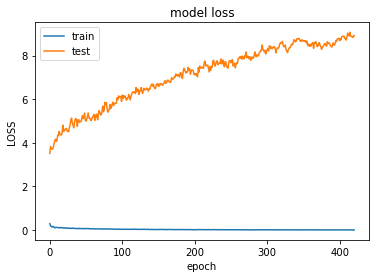

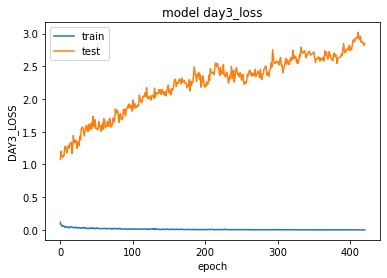

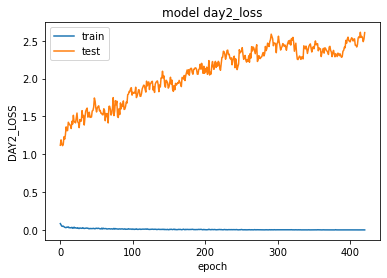

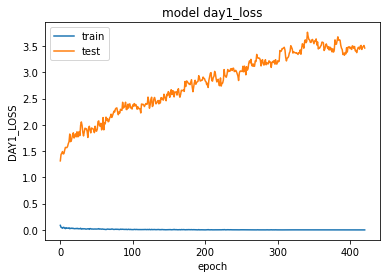

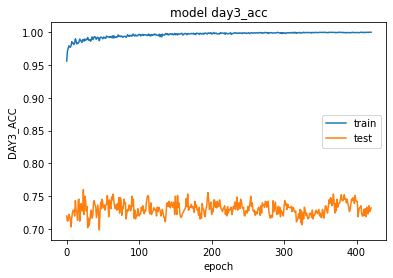

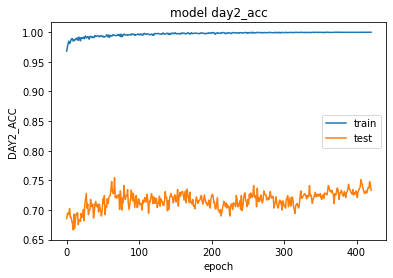

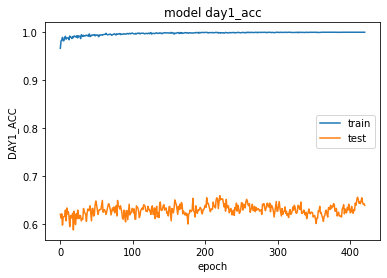

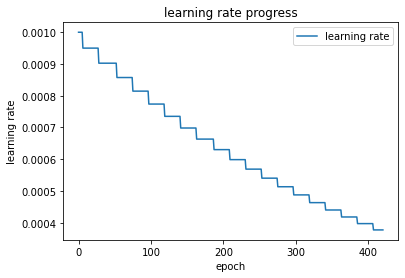

[[246 158]
 [165 327]]


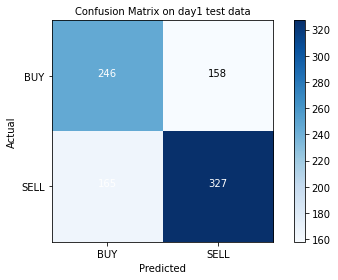

[[250 132]
 [107 407]]


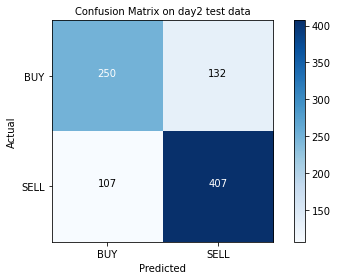

[[238 123]
 [117 418]]


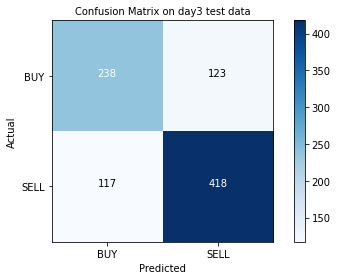

DAY1 ROC_AUC_SCORE:  0.6367725187152862
DAY2 ROC_AUC_SCORE:  0.7231395277772117
DAY3 ROC_AUC_SCORE:  0.7202940948041525
[*********************100%***********************]  1 of 1 completed
Directory  prediction  already exists
********************************************************************************
            actual  sell probability  buy probability  prediction   accuracy
Date                                                                        
2020-01-02     1.0      9.999530e-01         0.000047           1    correct
2020-01-03     0.0      2.026475e-09         1.000000           1  incorrect
2020-01-06     1.0      1.276537e-05         0.999987           0  incorrect
********************************************************************************
Prediction Accuracy : 0.3333333333333333


In [24]:
if best_model_search:
    if __name__ == '__main__':

        best_run, best_model = optim.minimize(model=create_transformer_model, data=data,functions = [data_params, data_split, feature_selection],algo=tpe.suggest,
                                              max_evals=max_evals,trials=Trials(), notebook_name=model_name,rseed=1, eval_space=True, verbose=False)

        batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler = data_params()
        x_train, x_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test,batch_size,hyperas_epochs,x_predict, forecast_period, last_date, ticker= data()
        print(x_train.shape, y1_train.shape, y2_train.shape,y3_train.shape)

        print("Evaluation of best performing model:")
        build_path('best_model')
        best_model.save('best_model/'+model_name+'.h5')
        f = open('best_model/'+model_name+'_best_run.pickle', 'wb')# save best_run parameters in a pickle file
        pickle.dump(best_run, f)
        f.close()
        #print(best_model.get_config())
        #print(best_model.metrics_names)
        loss, day3_loss, day2_loss, day1_loss, day3_accuracy, day2_accuracy, day1_accuracy, = best_model.evaluate([x_test, x_test, x_test], [y3_test,y2_test,y1_test], batch_size=batch_size)
        print('day1_accuracy: ', day1_accuracy, 'day2_accuracy: ',day2_accuracy, 'day3_accuracy: ',day3_accuracy)
        print("Best performing model chosen hyper-parameters:")
        print(best_run)
    
if  perform_training:
    kfold, train_size, shuffle, split, fold_number,random_state = data_split()
    batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler = data_params()           
    x_train, x_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, batch_size,hyperas_epochs,x_predict, forecast_period, last_date, ticker= data()
    best_model = load_model('best_model/'+model_name+'.h5')
    model = best_model
    training(model)
    del x_train, x_test,y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, x_predict

In [25]:
if not os.path.exists('train_model/'+model_name+'.h5'):
    print('Trained model doesnt exist, changing evaluate_all_folds to False')
    evaluate_all_folds = False
if evaluate_all_folds:
    kfold, train_size, shuffle, split, fold_number,random_state = data_split()
    batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler = data_params()    
    df, y, ticker = feature_selection()
    model = load_model('train_model/'+model_name+'.h5')
    print('loaded trained model')
    
    # add percent change
    df=df.pct_change()
    df=df.replace([np.inf, -np.inf],np.nan) 
    df.fillna(0, inplace=True)
    df.isnull().any().mean()
    
    # apply preprocessing 
    x = x_scaler.fit_transform(df)
    del df
    y = y.values

    # apply time steps
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X[i:(i + time_steps)]
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)
    x, y = create_dataset(x, y, time_steps)
    
    # forecast periods and removing last7 rows (for the target being NaN for 7 day model)
    x = x[:-forecast_period]
    y =  y[:-forecast_period]

    #implementation of fold
    print('started Kfold')

    count = 0
    fd = KFold(n_splits=split, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in fd.split(x):
        count +=1
        print('processing fold number ', count)

        _, x_test,_, y_test  = x[train_index], x[test_index], y[train_index], y[test_index]
        
        
        y1_test = np_utils.to_categorical(y_test[:,:1], 2, dtype='float32')   
        y2_test = np_utils.to_categorical(y_test[:,1:2], 2, dtype='float32')
        y3_test = np_utils.to_categorical(y_test[:,2:3], 2, dtype='float32') 
        #y4_test = np_utils.to_categorical(y_test[:,3:4], 2, dtype='float32')
        #y5_test = np_utils.to_categorical(y_test[:,4:5], 2, dtype='float32')
        #y6_test = np_utils.to_categorical(y_test[:,5:6], 2, dtype='float32')
        #y7_test = np_utils.to_categorical(y_test[:,6:], 2, dtype='float32')

        # adjustment for batch_size
          
        test_start = x_test.shape[0]%batch_size
          
        x_test = x_test[test_start:]
        y1_test = y1_test[test_start:]
        y2_test = y2_test[test_start:]
        y3_test = y3_test[test_start:]
        #y4_test = y4_test[test_start:]
        #y5_test = y5_test[test_start:]
        #y6_test = y6_test[test_start:]
        #y7_test = y7_test[test_start:]
         
        
        loss, day3_loss, day2_loss, day1_loss, day3_accuracy, day2_accuracy, day1_accuracy = model.evaluate([x_test, x_test, x_test], [y3_test,y2_test,y1_test], batch_size=batch_size)
        
        print('Fold Number ', count, 'day1_accuracy: ', day1_accuracy, 'day2_accuracy: ',day2_accuracy, 'day3_accuracy: ',day3_accuracy)
       
        del x_test, y1_test, y2_test, y3_test

removed columns:  []
rolling mean columns added:  42
loaded trained model
started Kfold
processing fold number  1
640/640 [==============================] - 2s 3ms/sample - loss: 7.6042 - day3_loss: 2.4416 - day2_loss: 2.3482 - day1_loss: 2.8145 - day3_acc: 0.7266 - day2_acc: 0.7109 - day1_acc: 0.6313
Fold Number  1 day1_accuracy:  0.63125 day2_accuracy:  0.7109375 day3_accuracy:  0.7265625
processing fold number  2
640/640 [==============================] - 1s 907us/sample - loss: 4.3077 - day3_loss: 1.4270 - day2_loss: 1.2125 - day1_loss: 1.6682 - day3_acc: 0.8313 - day2_acc: 0.8266 - day1_acc: 0.8047
Fold Number  2 day1_accuracy:  0.8046875 day2_accuracy:  0.8265625 day3_accuracy:  0.83125
processing fold number  3
640/640 [==============================] - 1s 911us/sample - loss: 0.0094 - day3_loss: 4.0882e-04 - day2_loss: 0.0089 - day1_loss: 6.7320e-05 - day3_acc: 1.0000 - day2_acc: 0.9984 - day1_acc: 1.0000
Fold Number  3 day1_accuracy:  1.0 day2_accuracy:  0.9984375 day3_accurac